In [1]:
import exmel
dataset = exmel.Dataset("dataset")

Melody plot saved to: results/My Heart Will Go On.png
Melody plot saved to: results/不为谁而作的歌.png
Melody plot saved to: results/以父之名.png
Melody plot saved to: results/光年之外.png
Melody plot saved to: results/凉凉.png
Melody plot saved to: results/唯一.png
Melody plot saved to: results/想见你想见你想见你.png
Melody plot saved to: results/慢慢喜欢你.png
Melody plot saved to: results/明天会更好.png
Melody plot saved to: results/是妈妈是女儿.png
Melody plot saved to: results/暗号.png
Melody plot saved to: results/月牙湾.png
Melody plot saved to: results/来迟.png
Melody plot saved to: results/梦一场.png
Melody plot saved to: results/给电影人的情书.png
Melody plot saved to: results/野子.png
Melody plot saved to: results/黑暗骑士.png


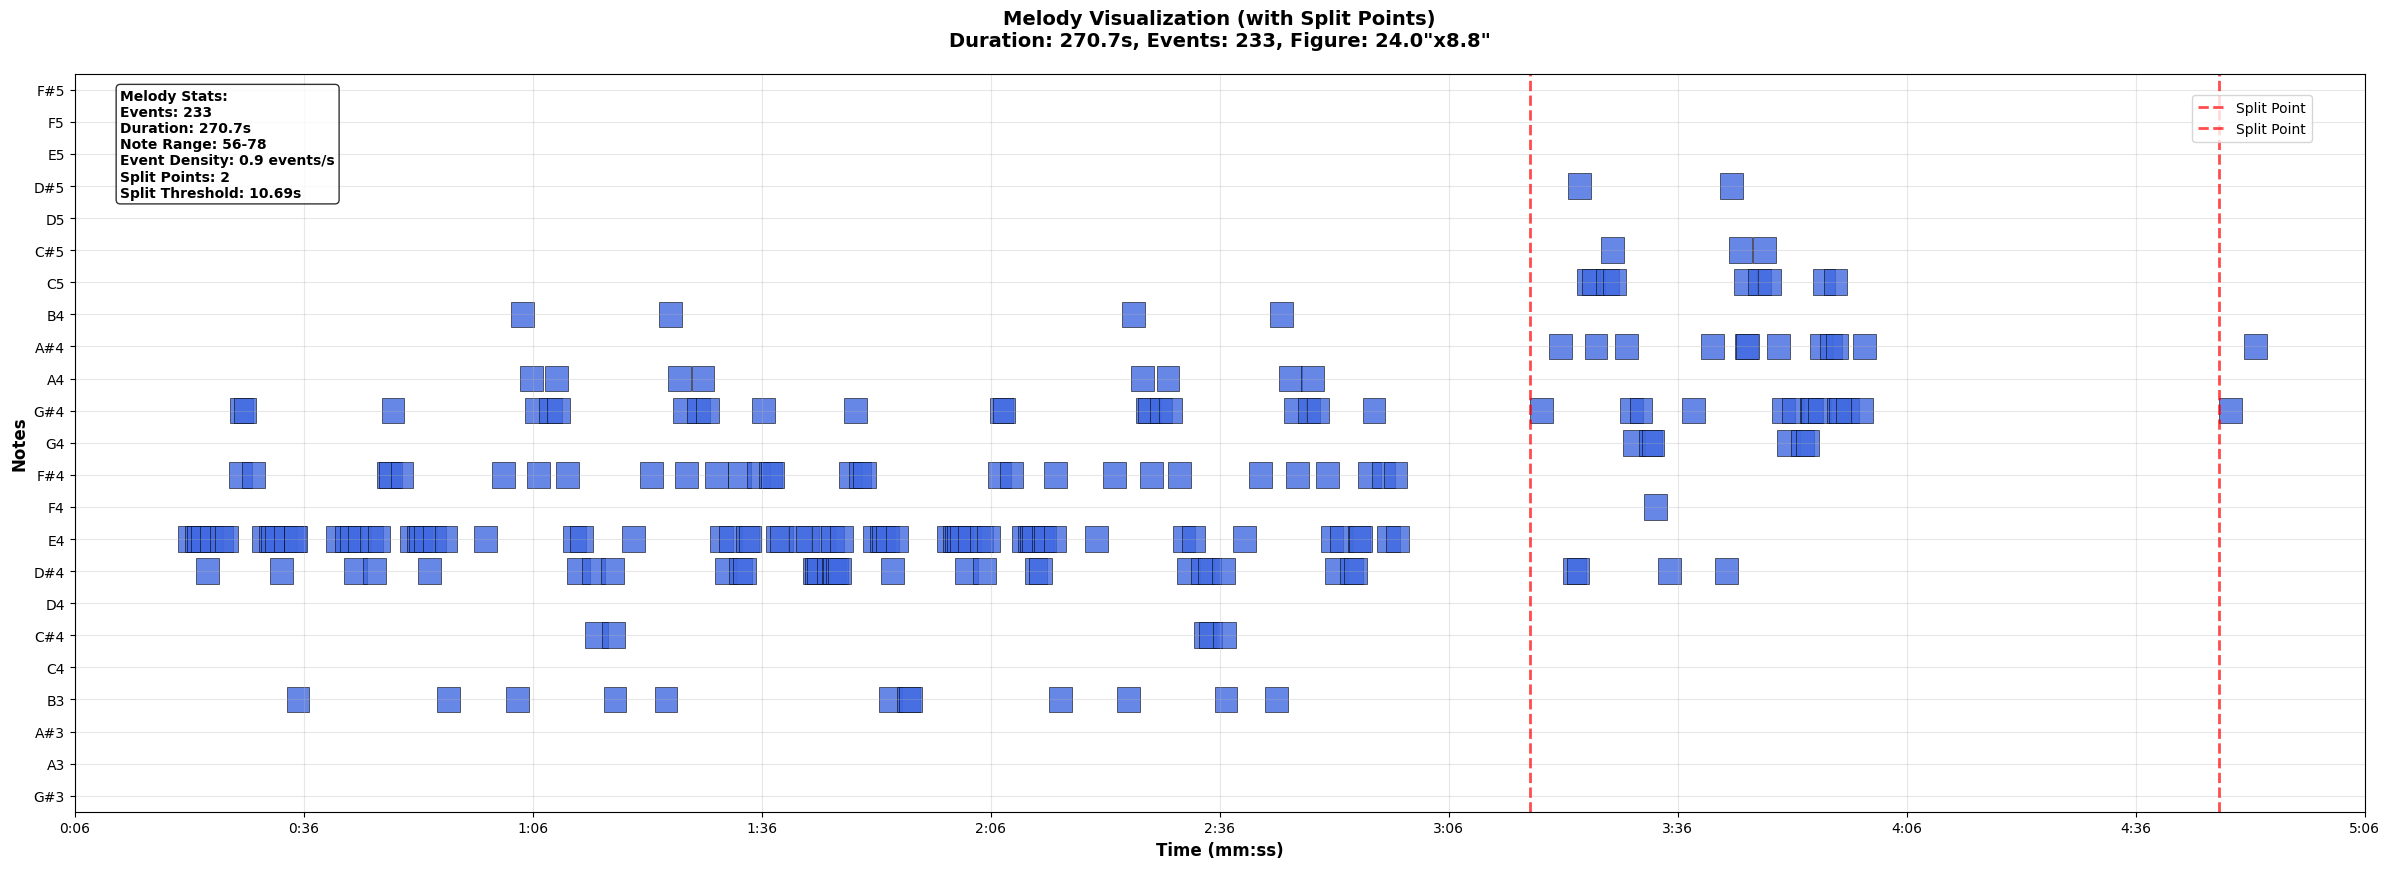

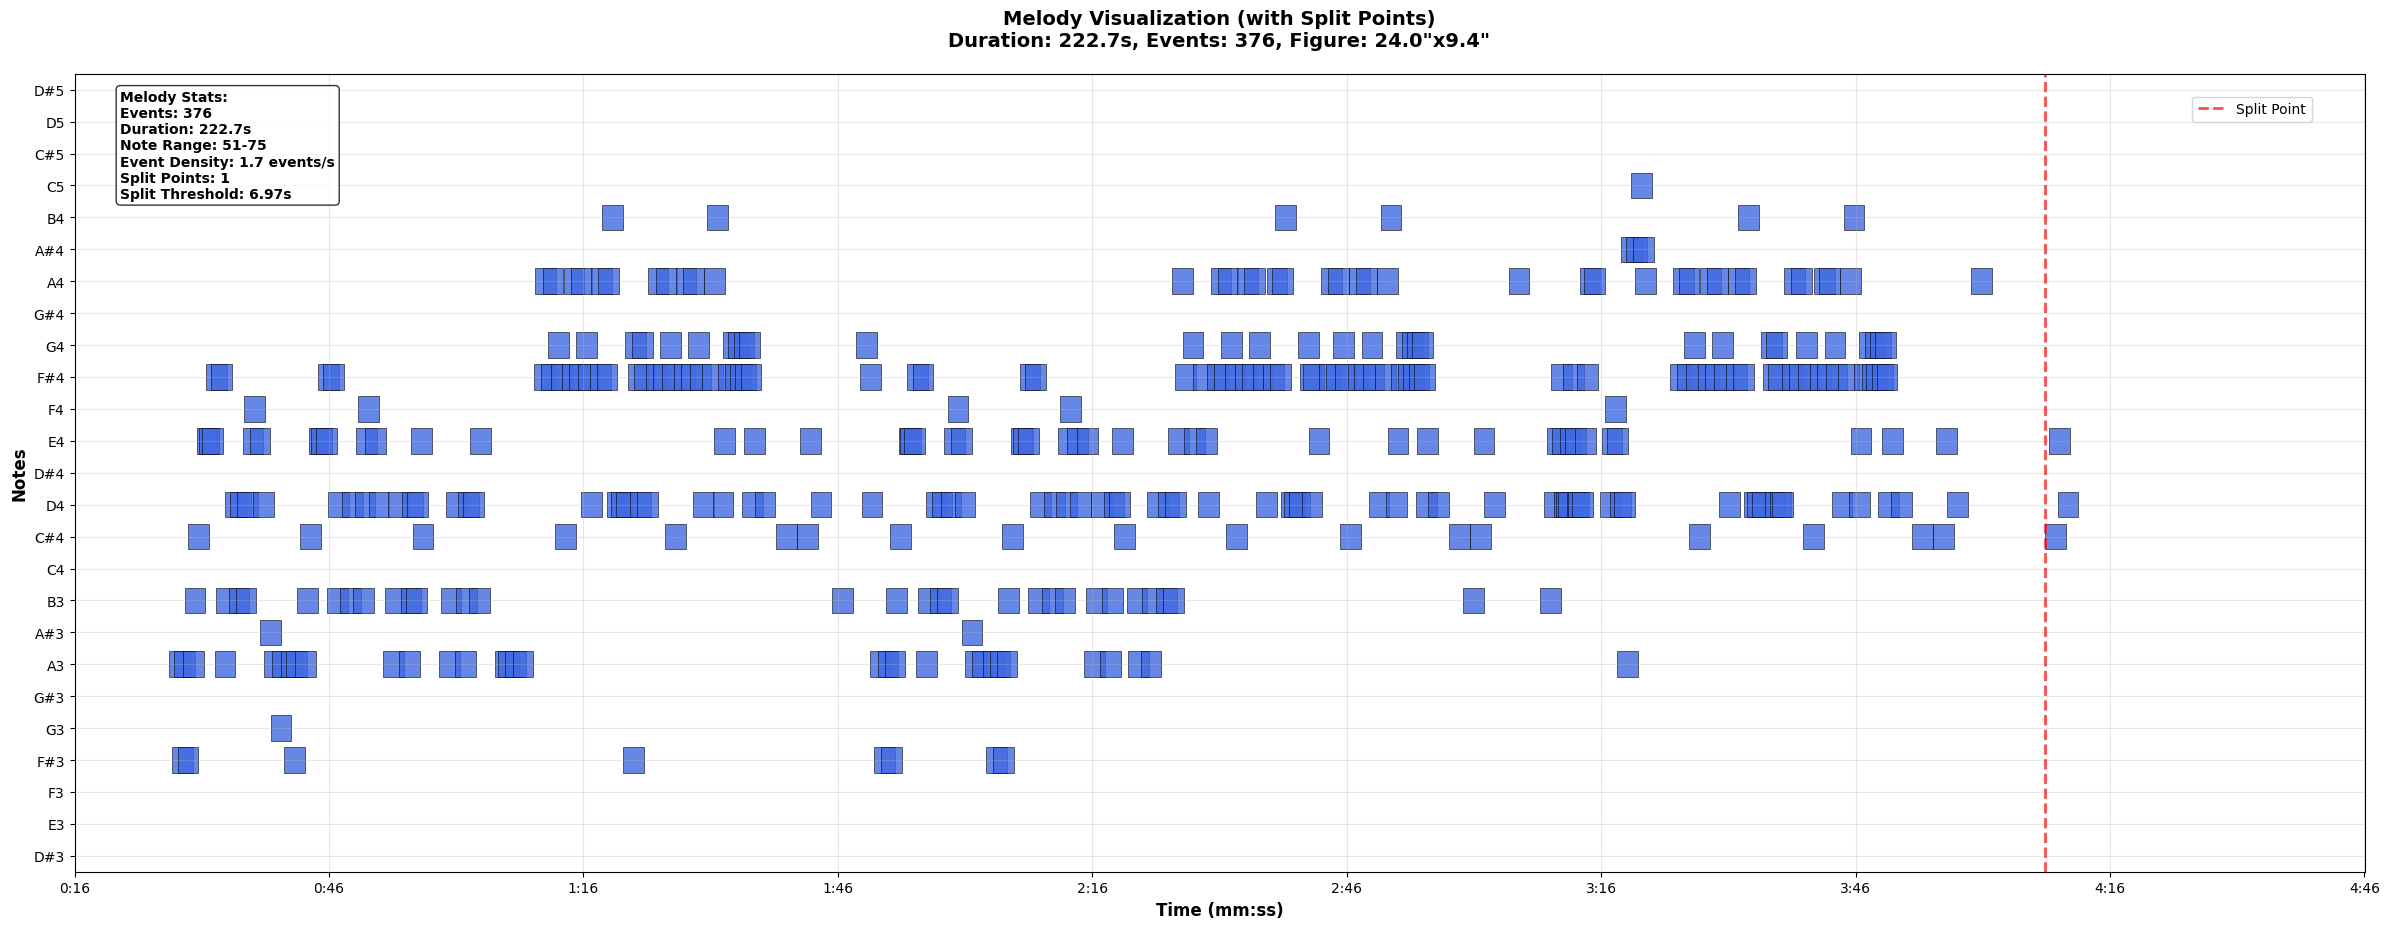

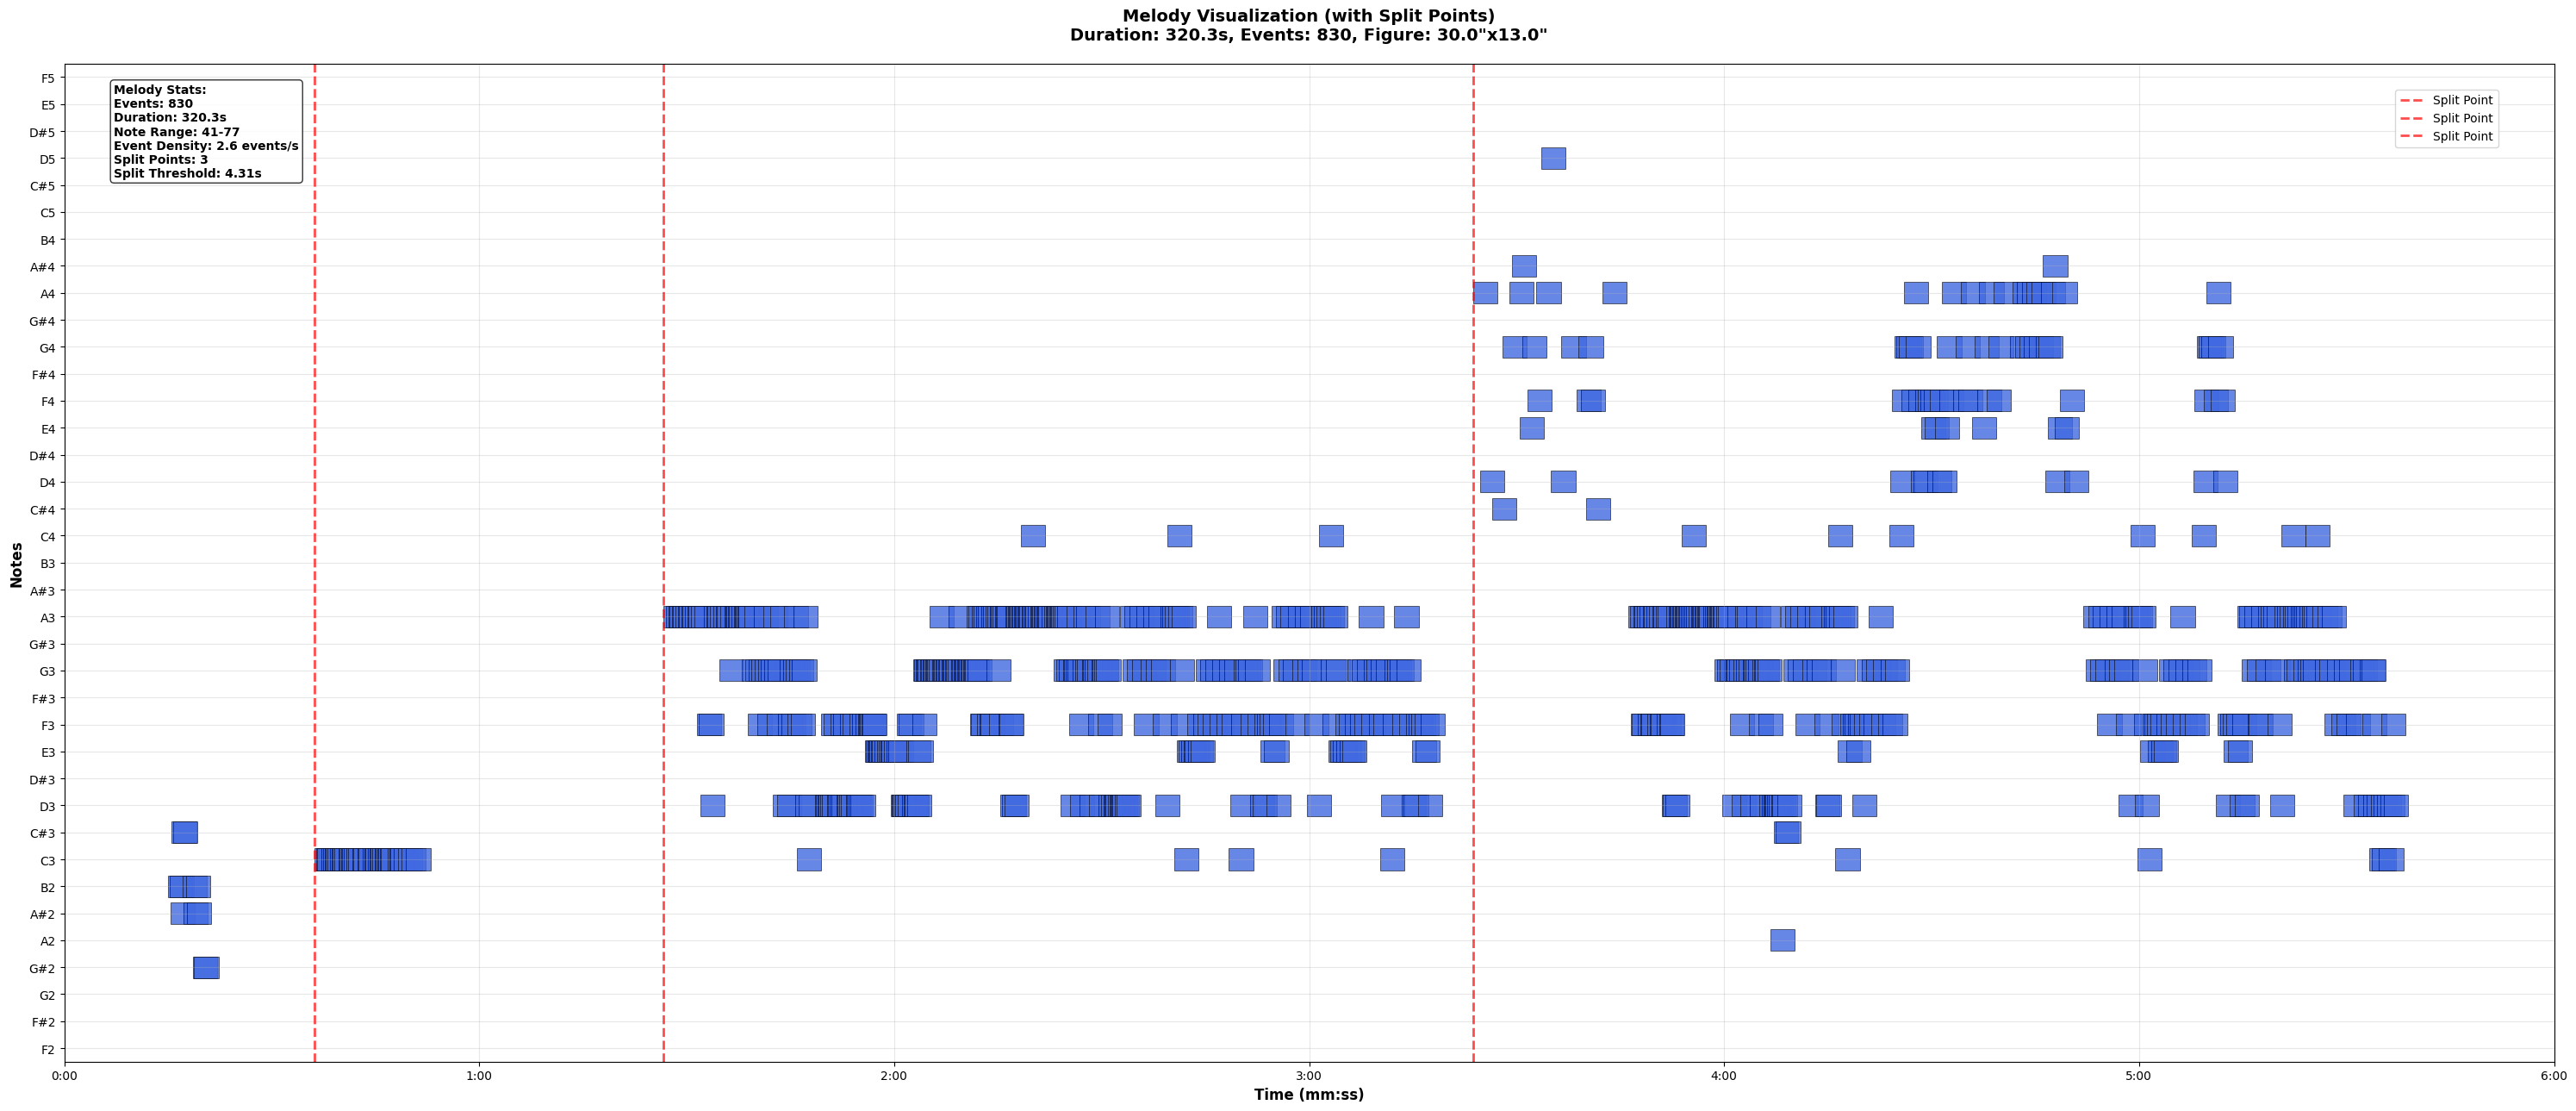

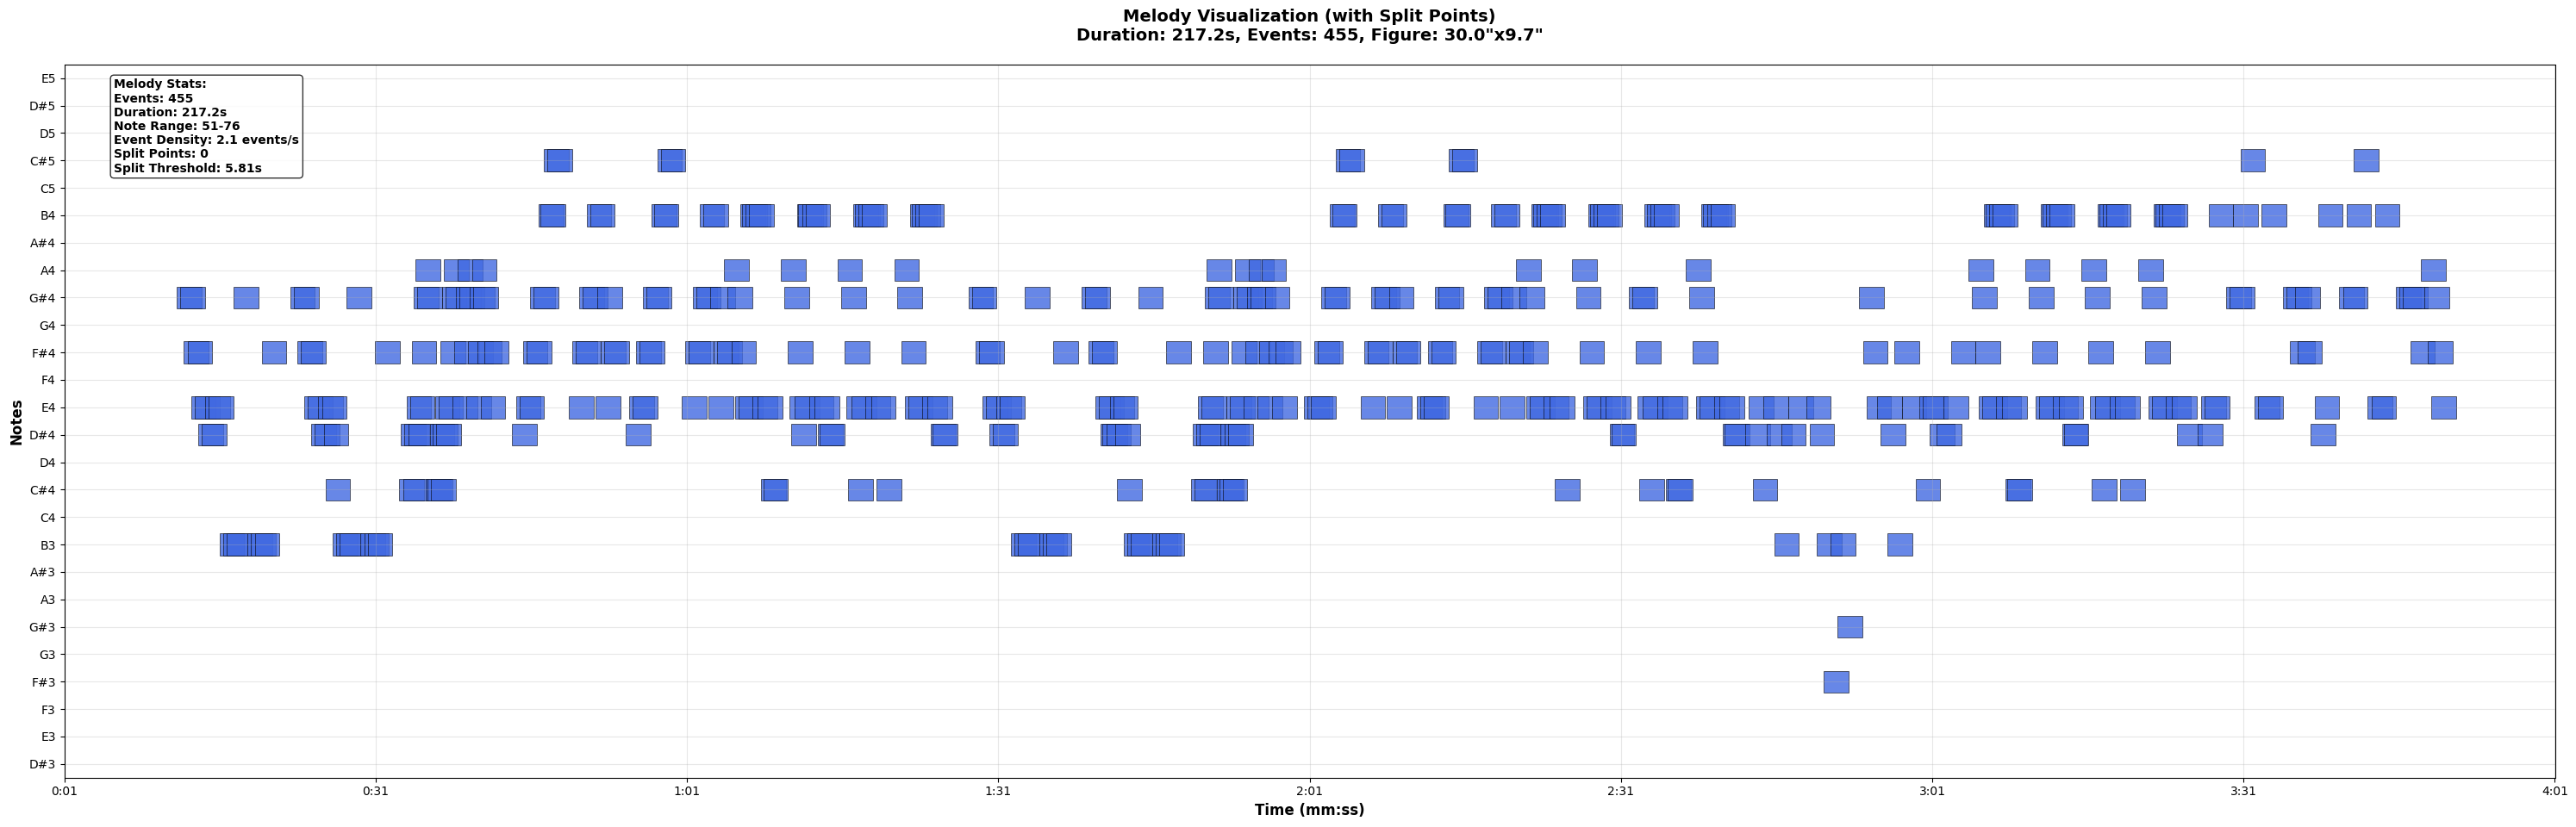

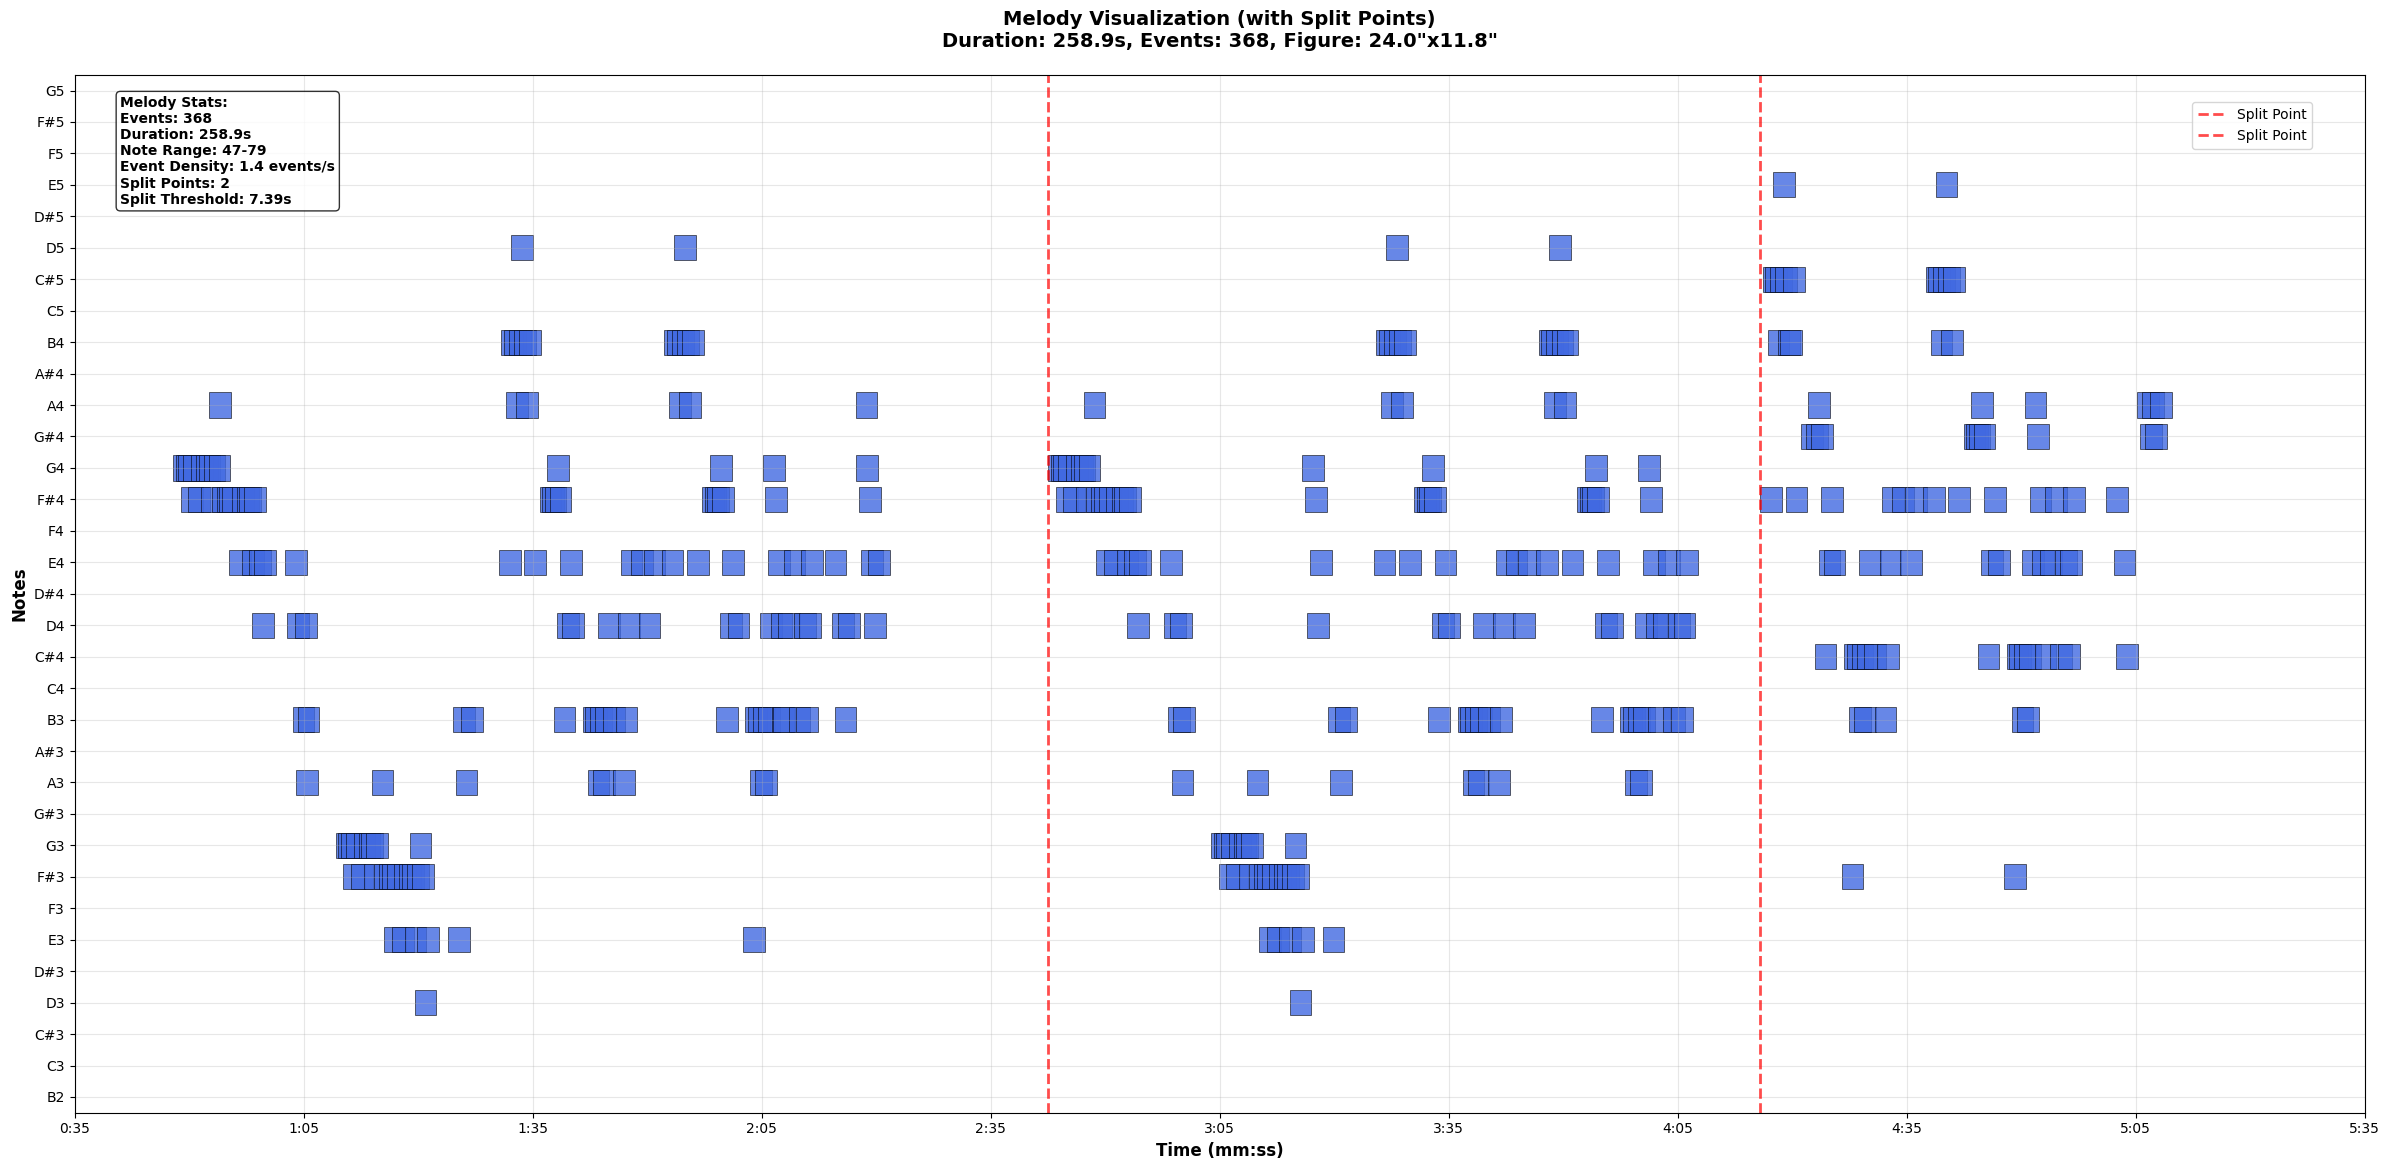

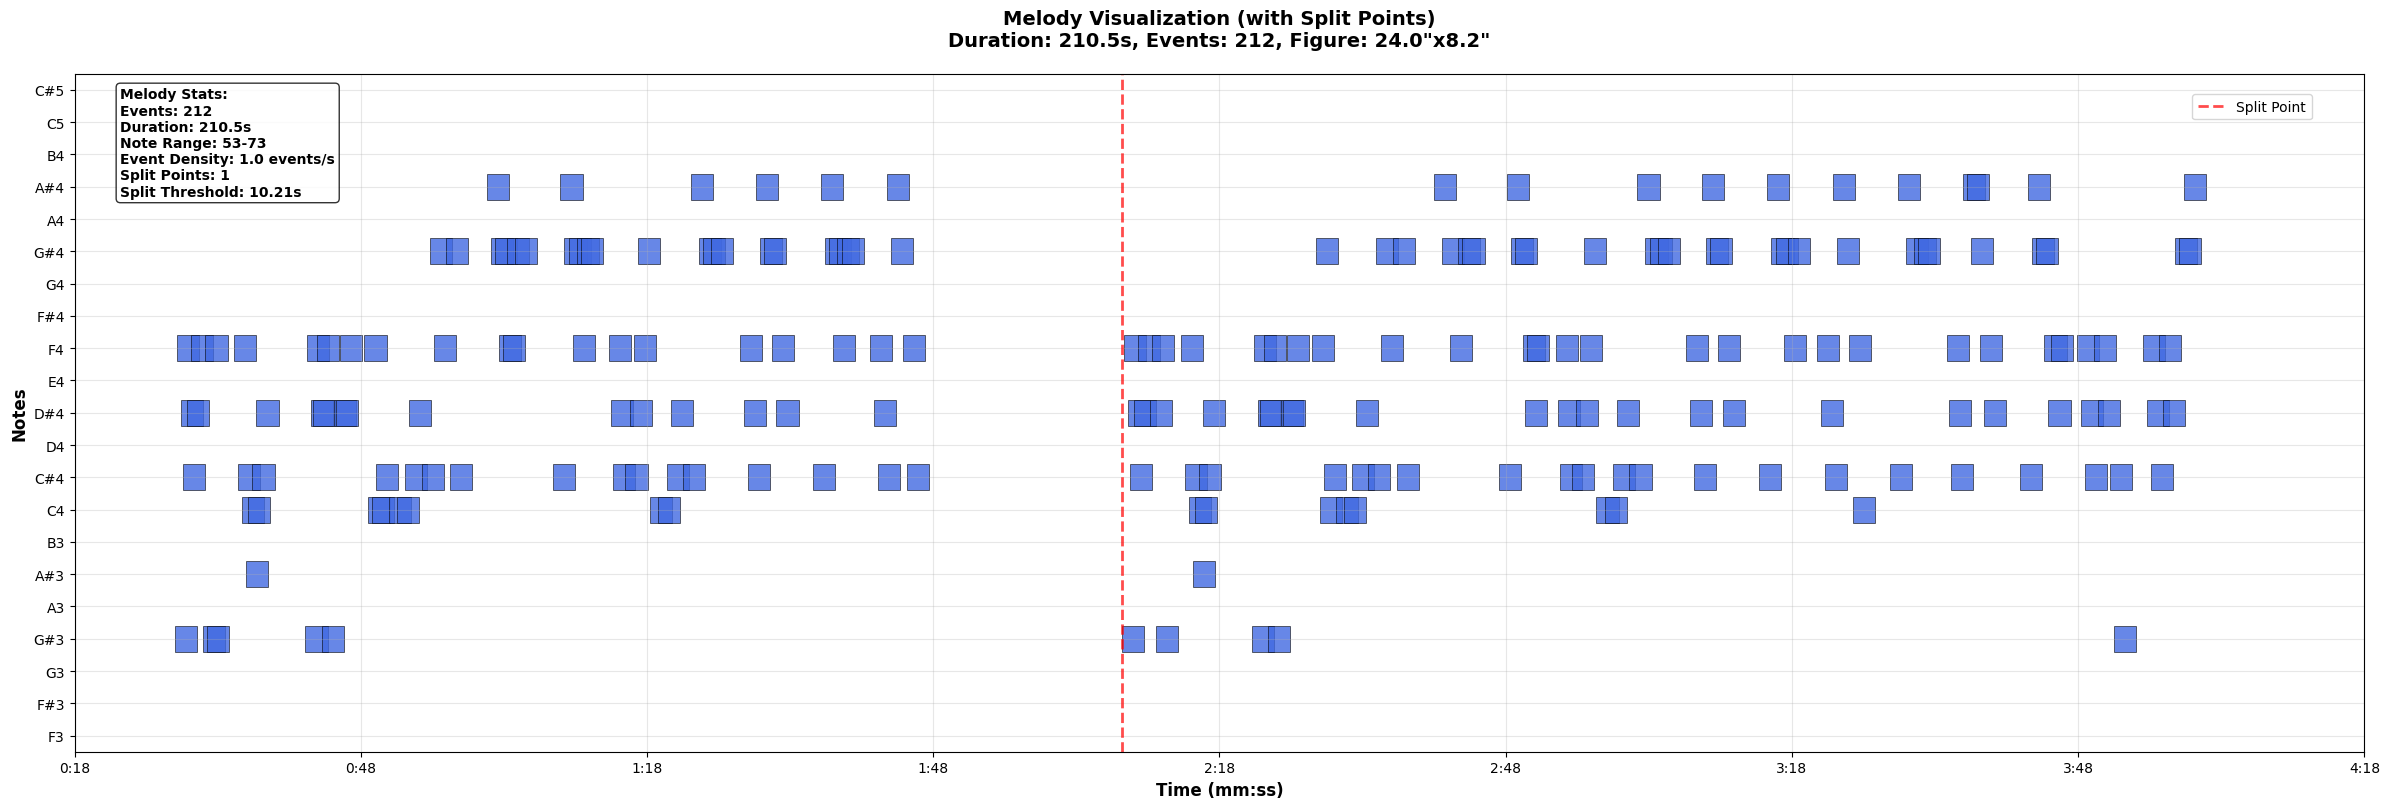

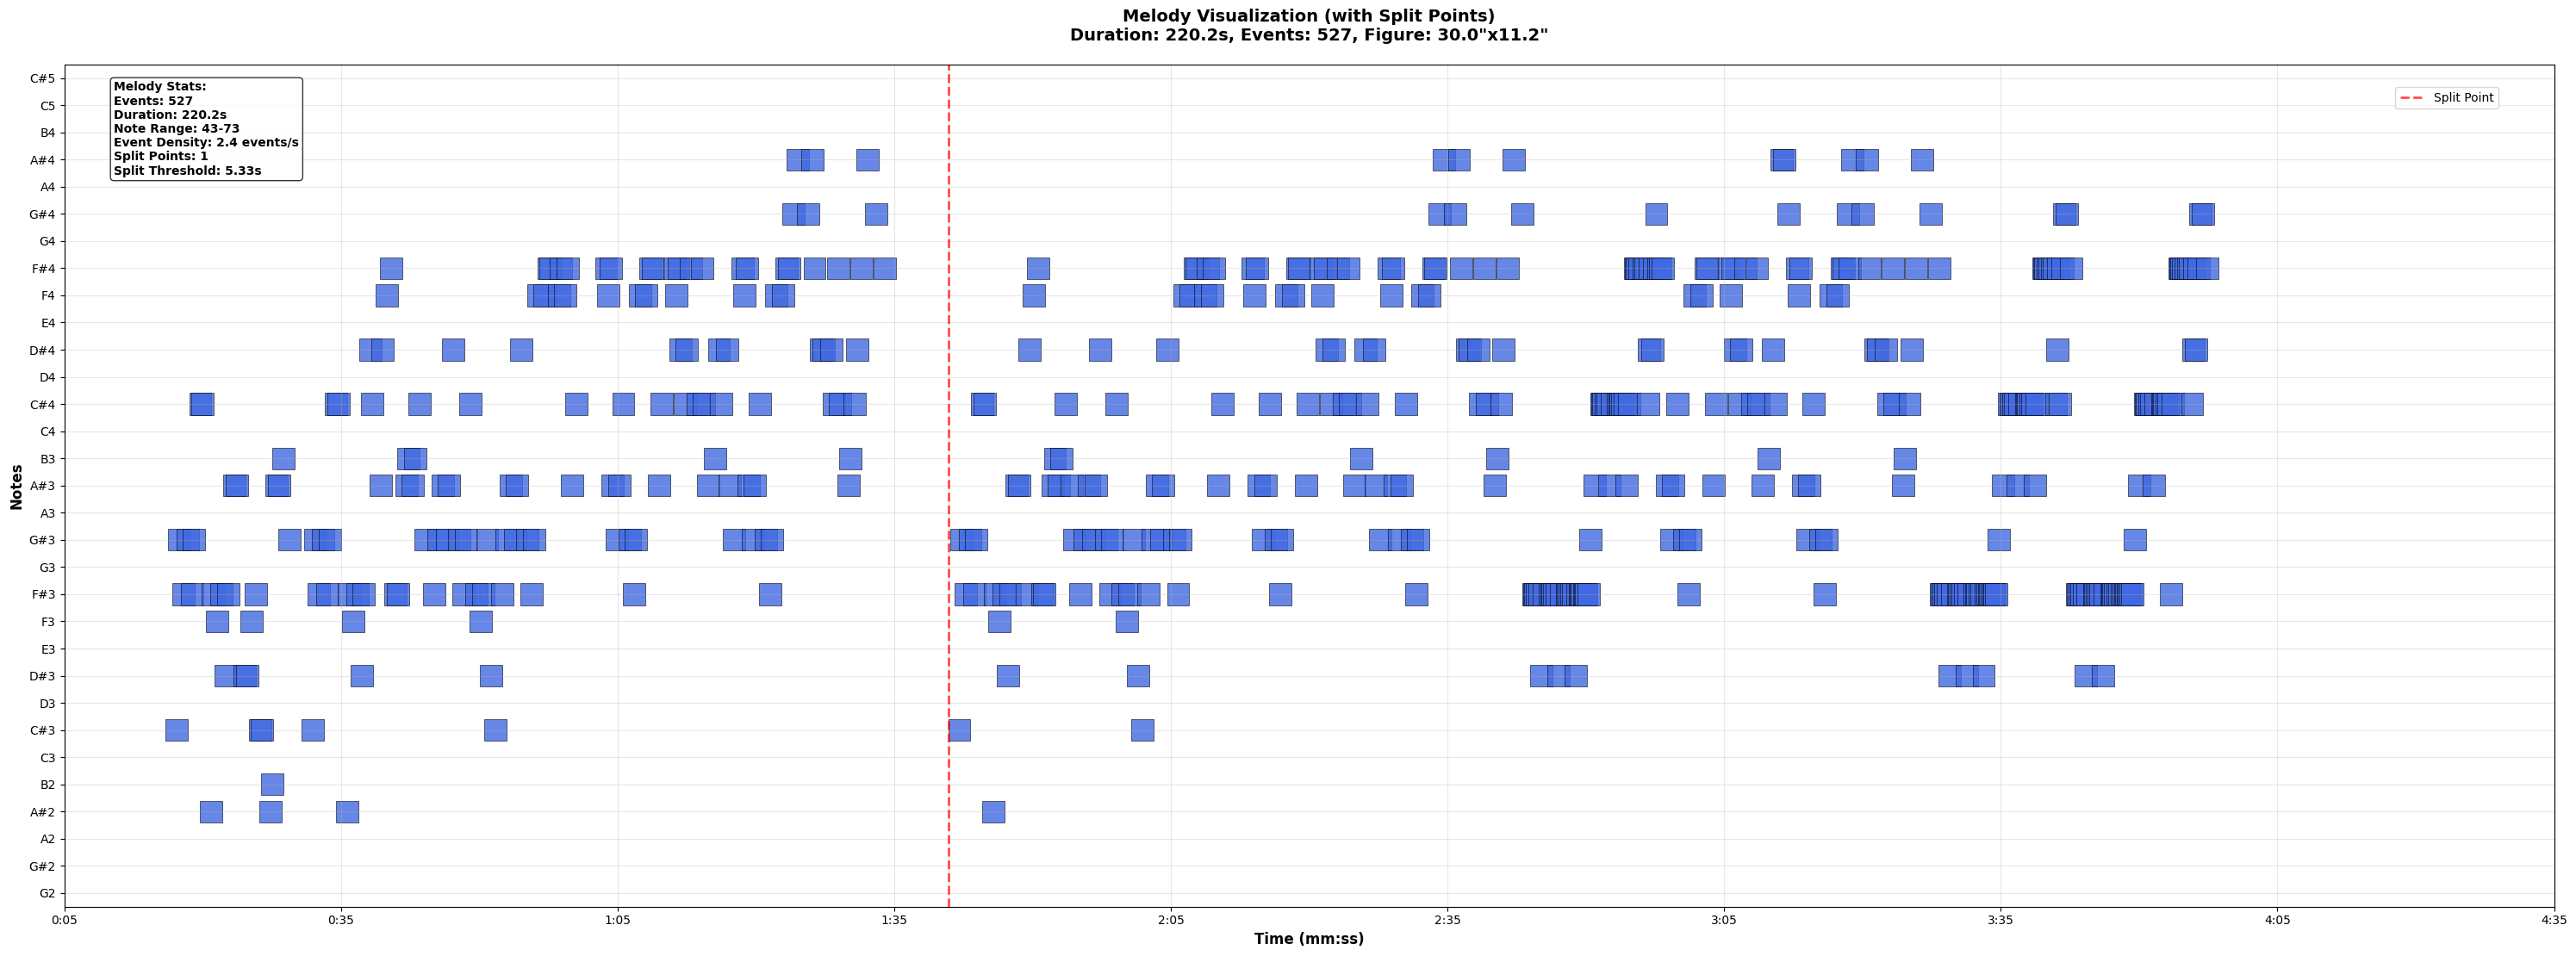

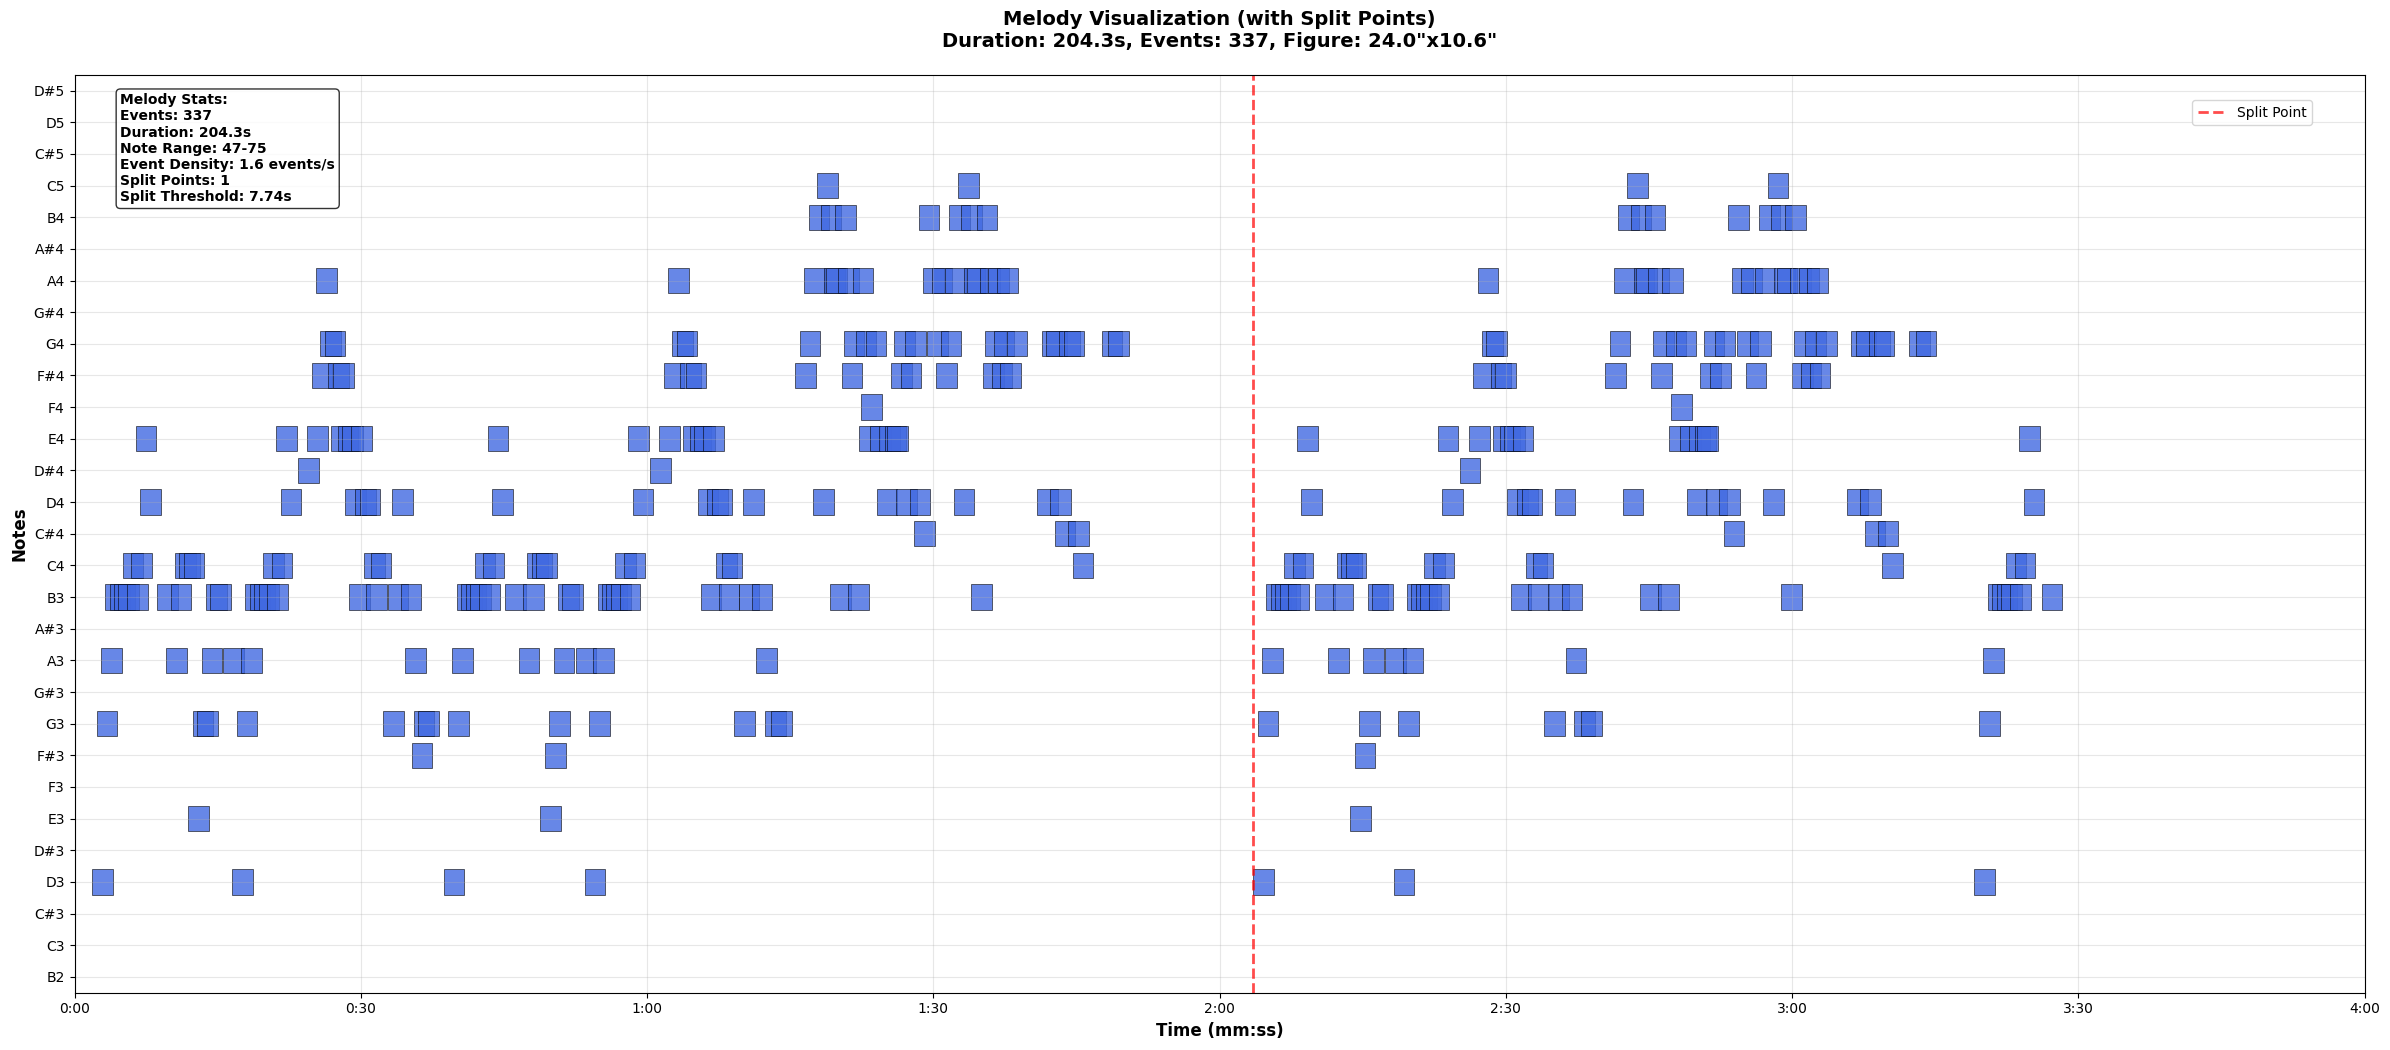

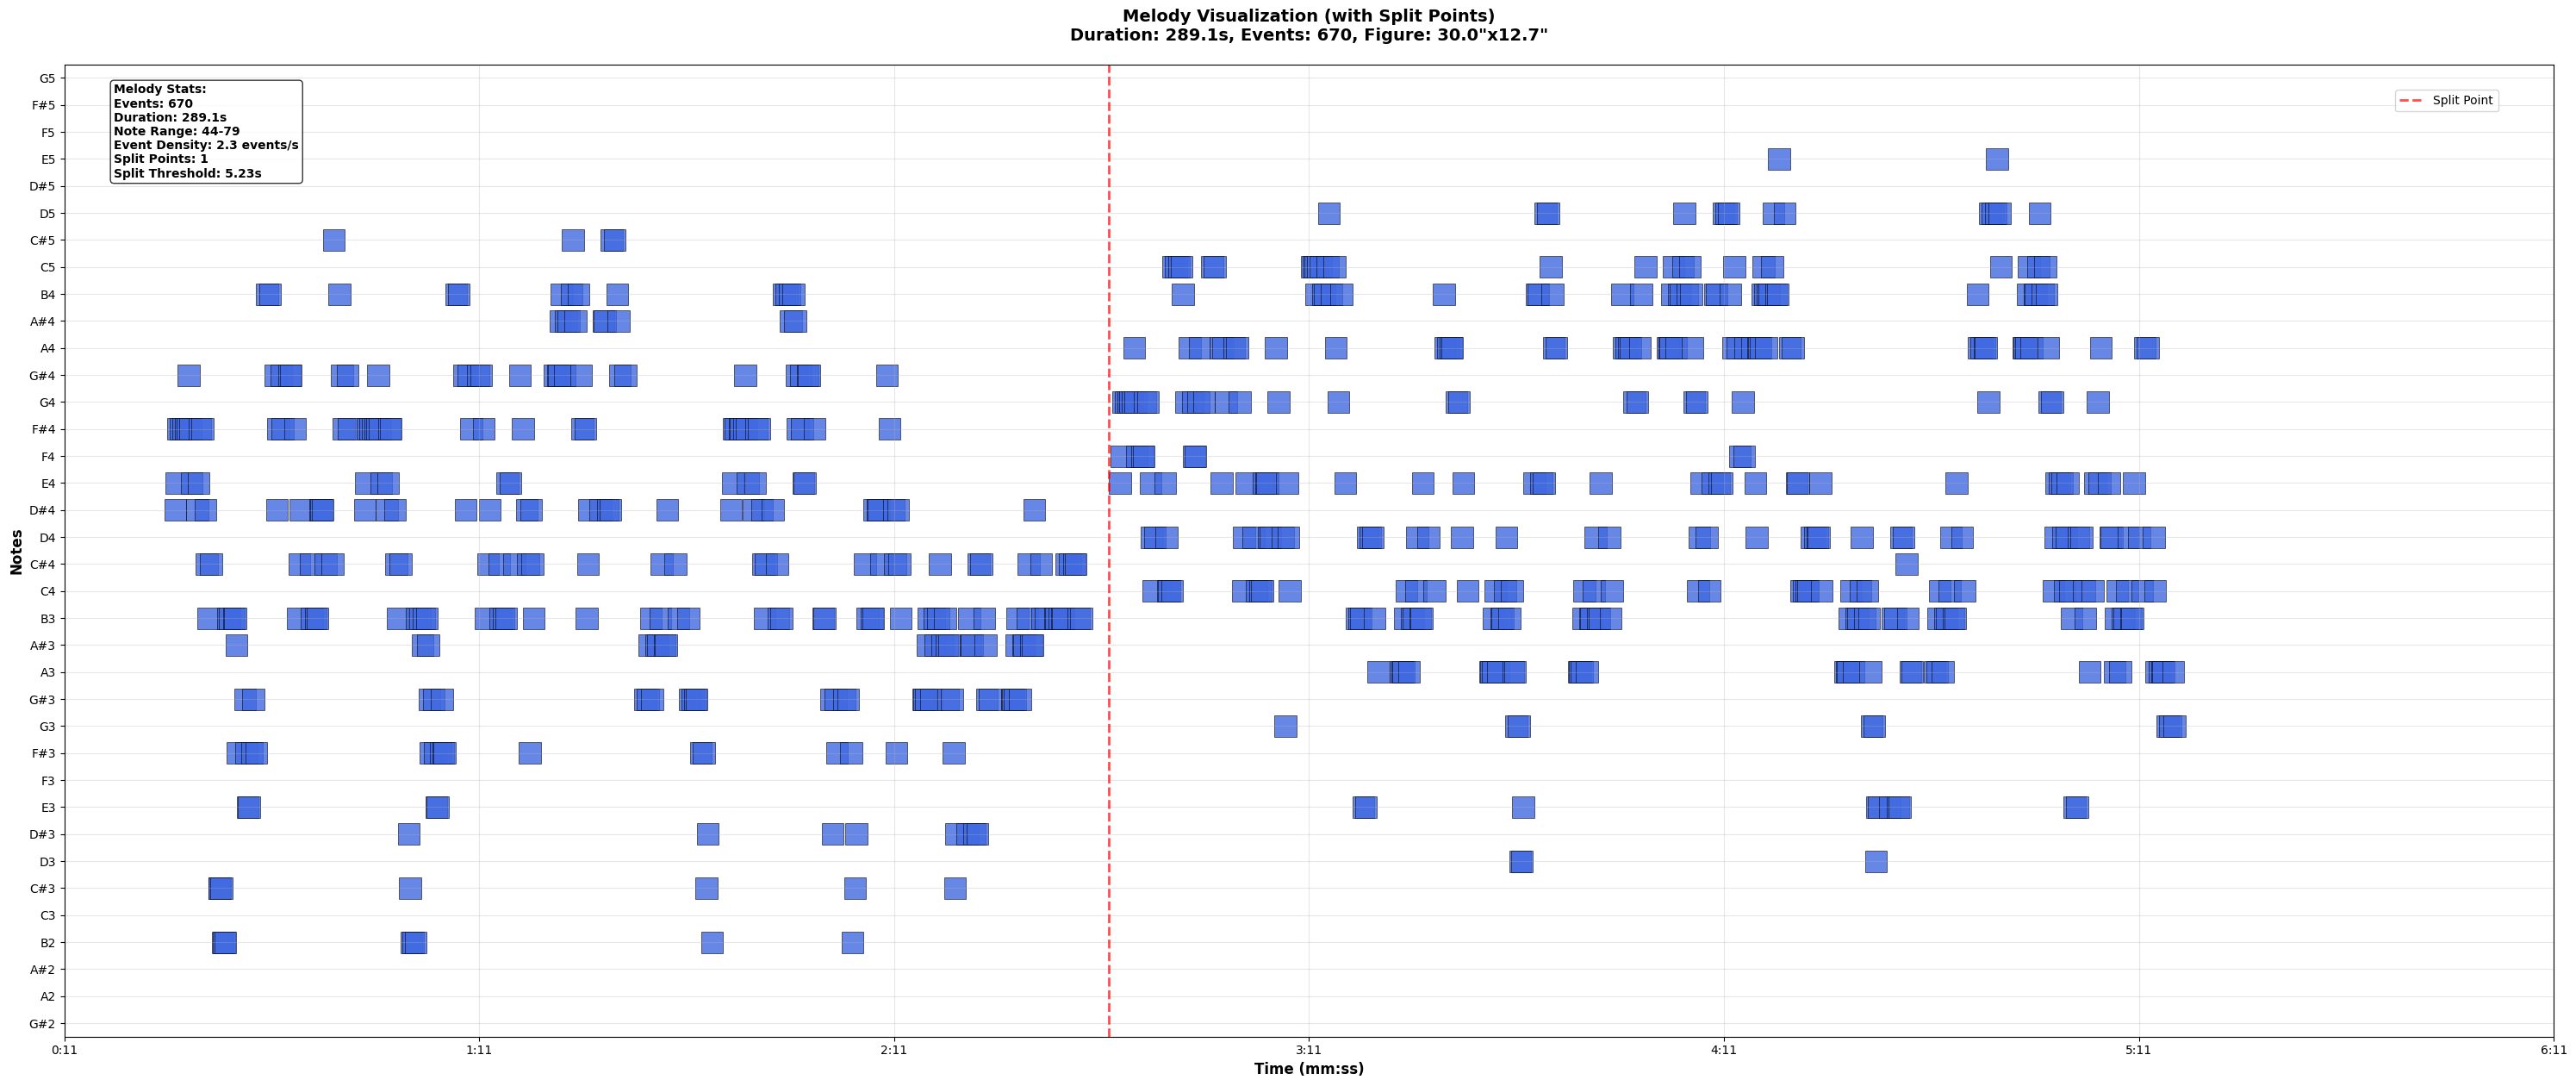

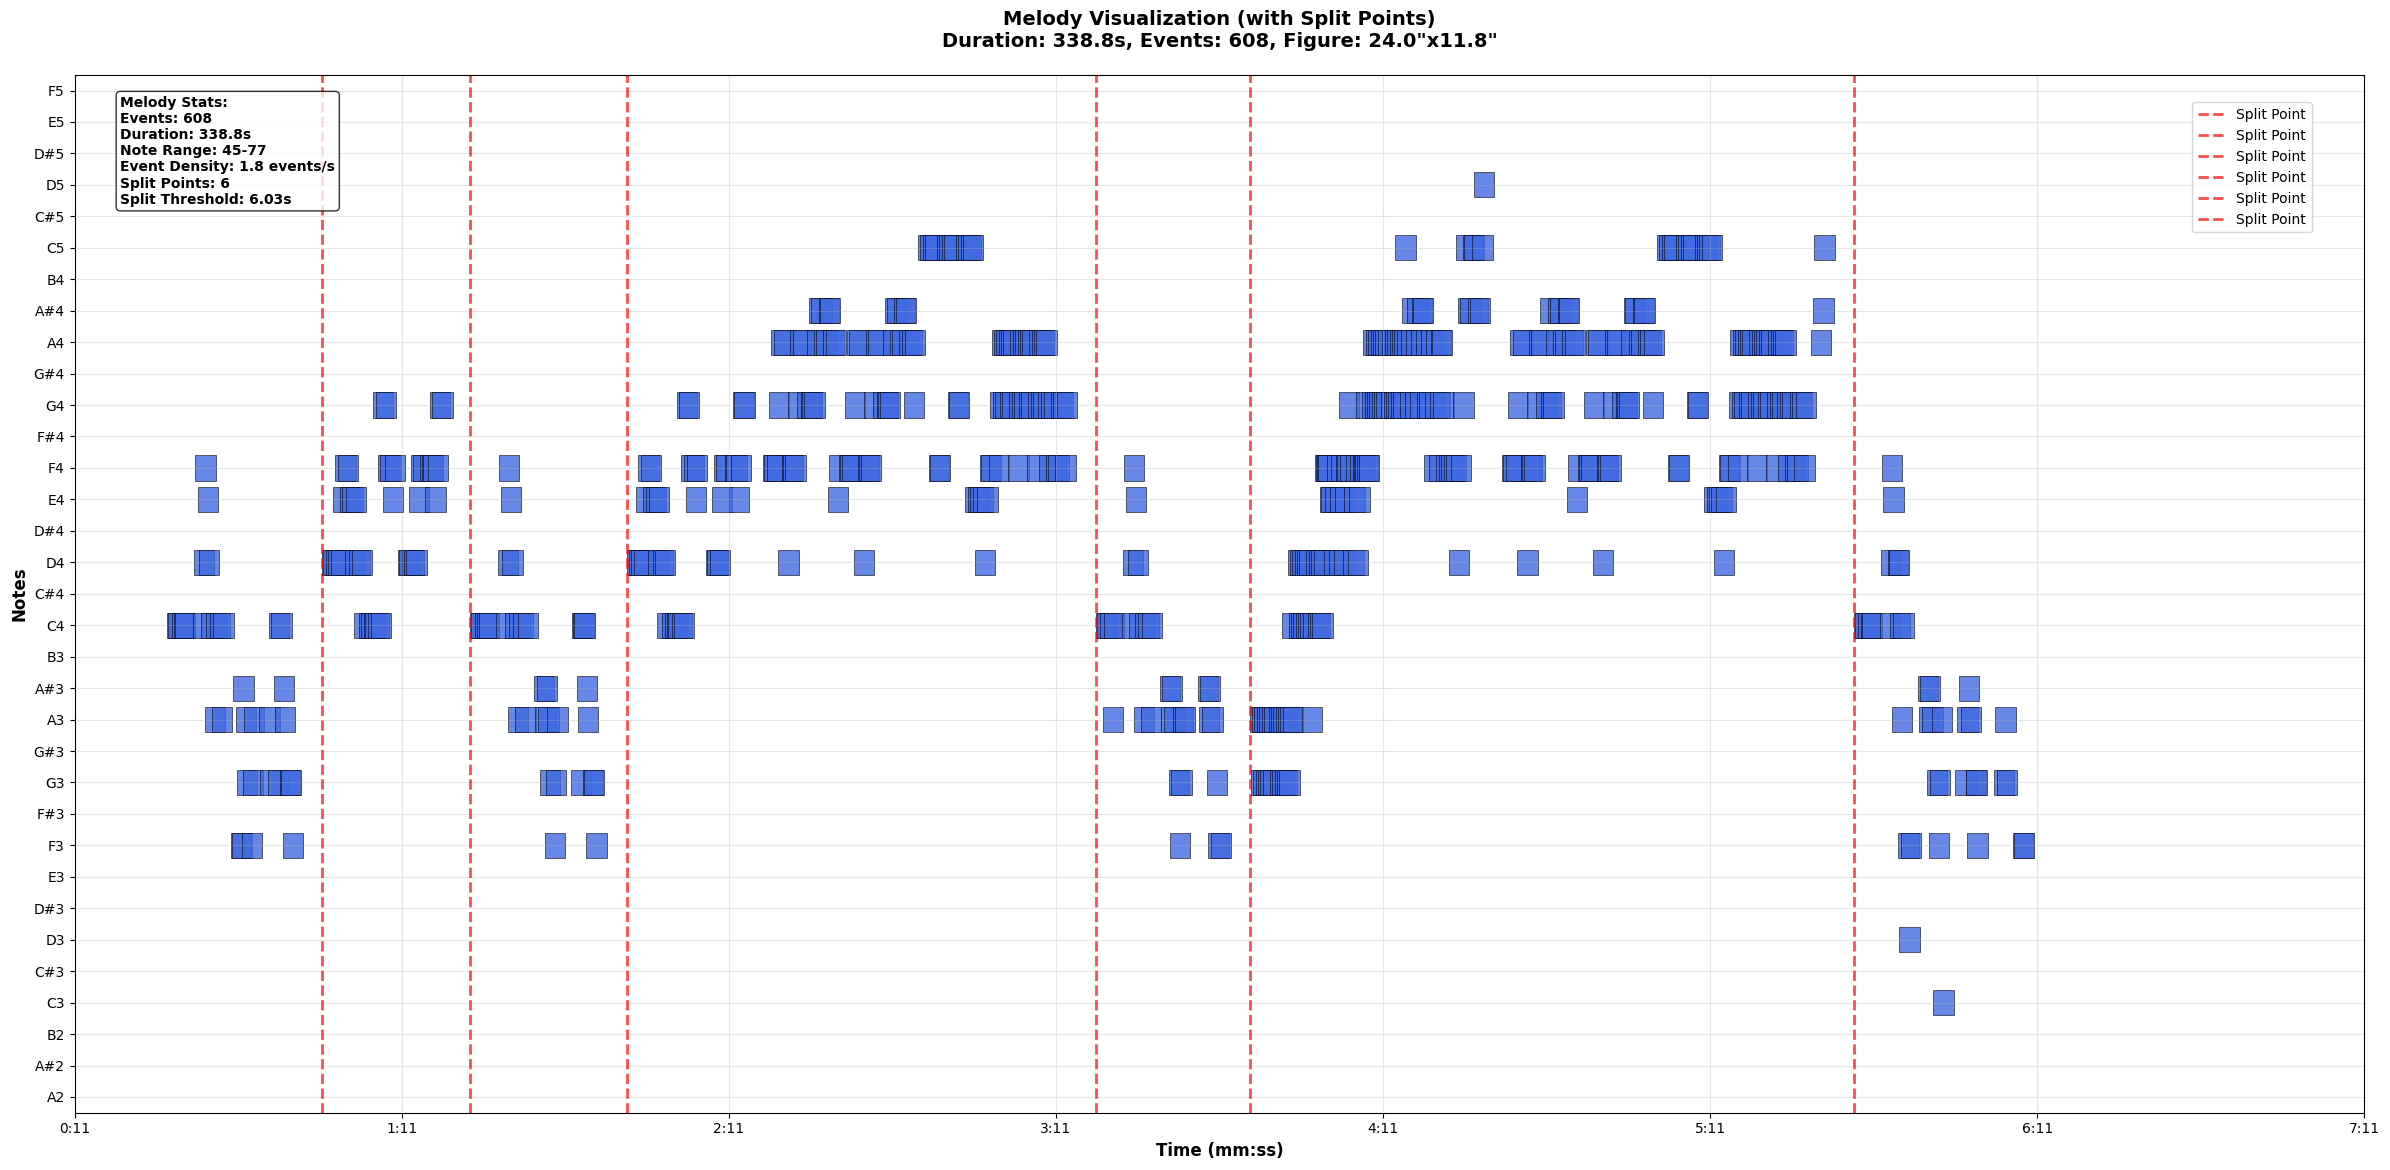

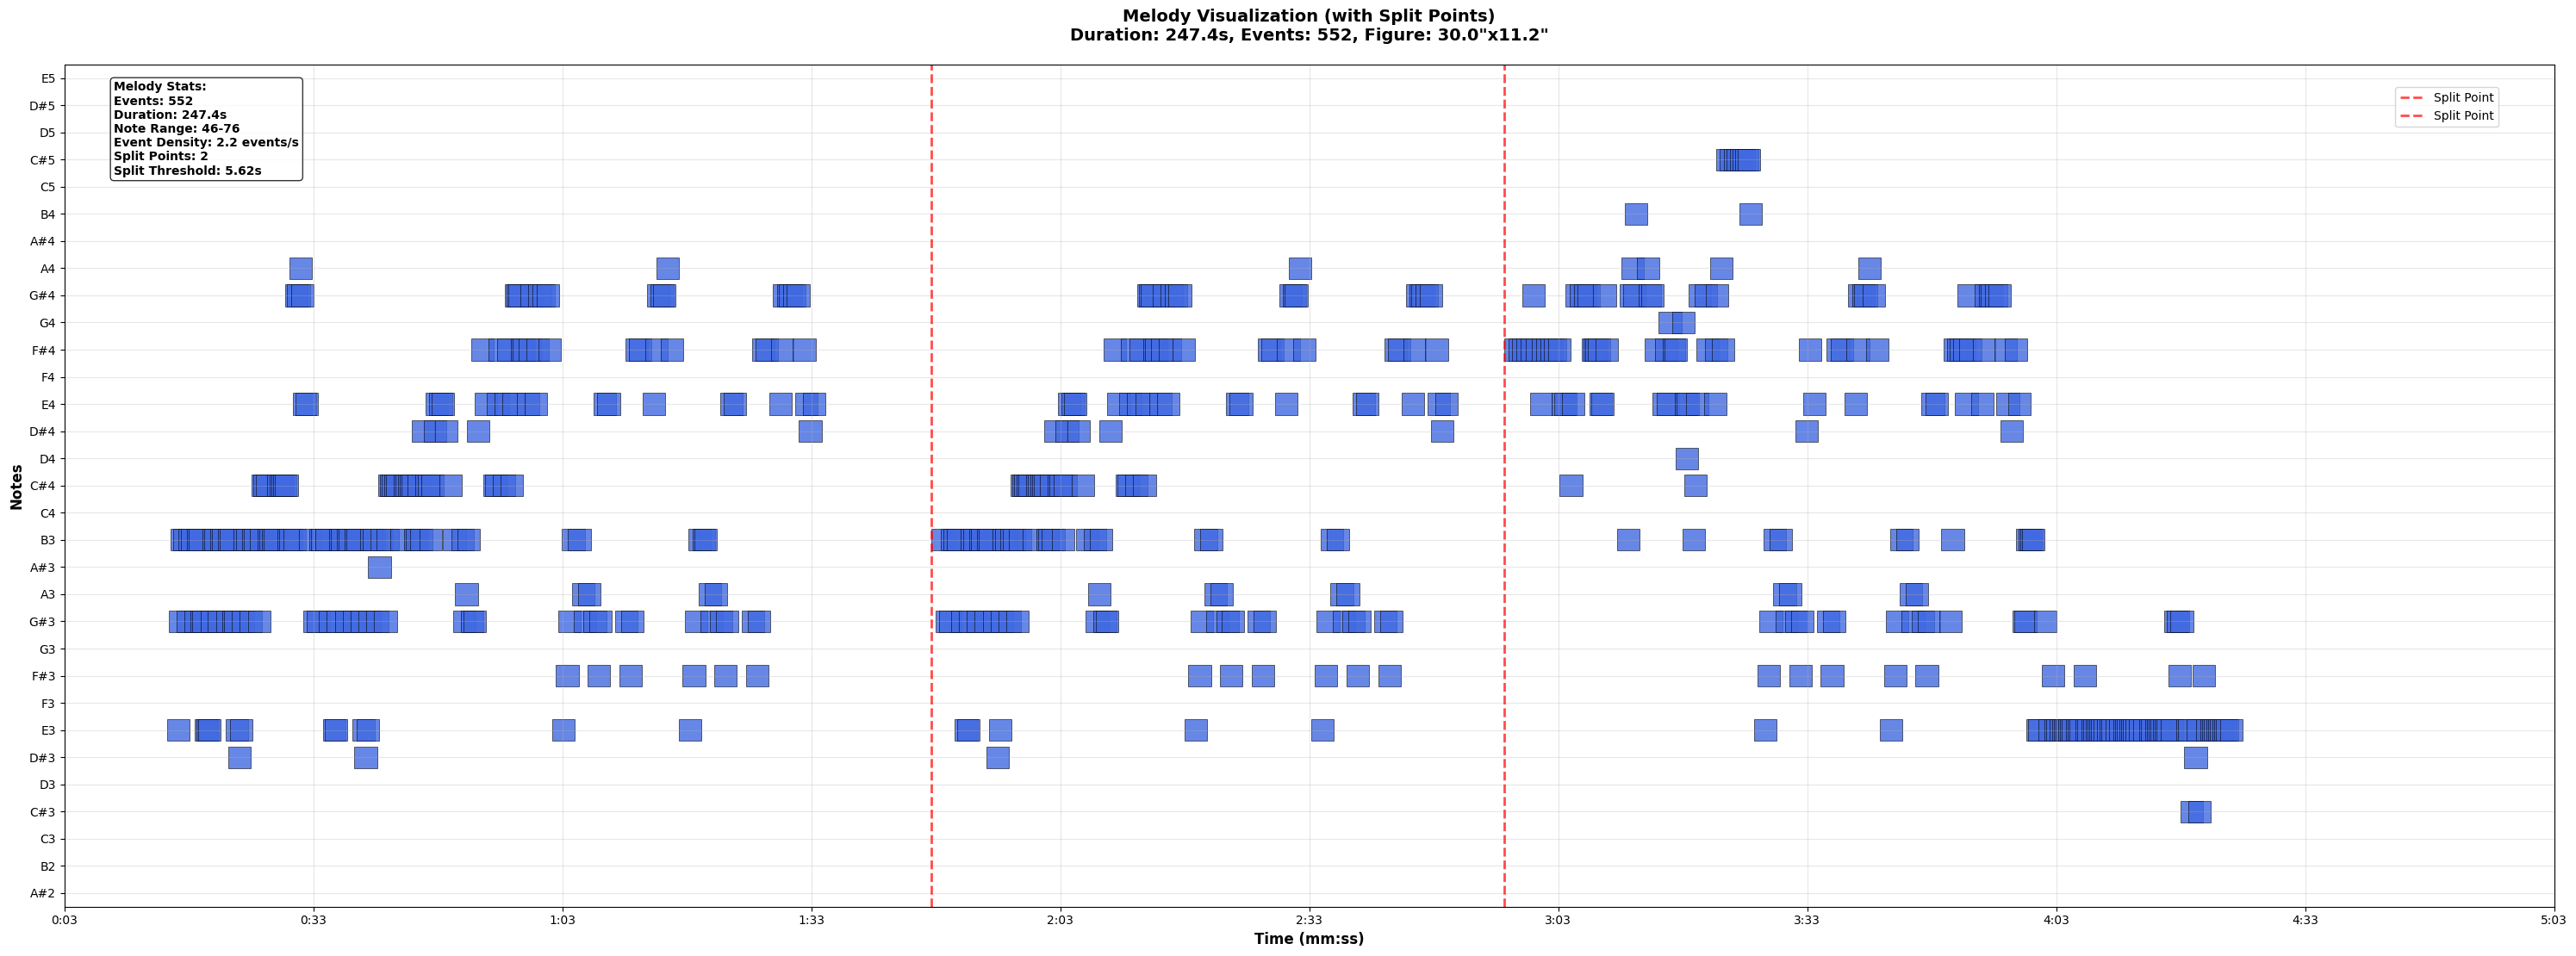

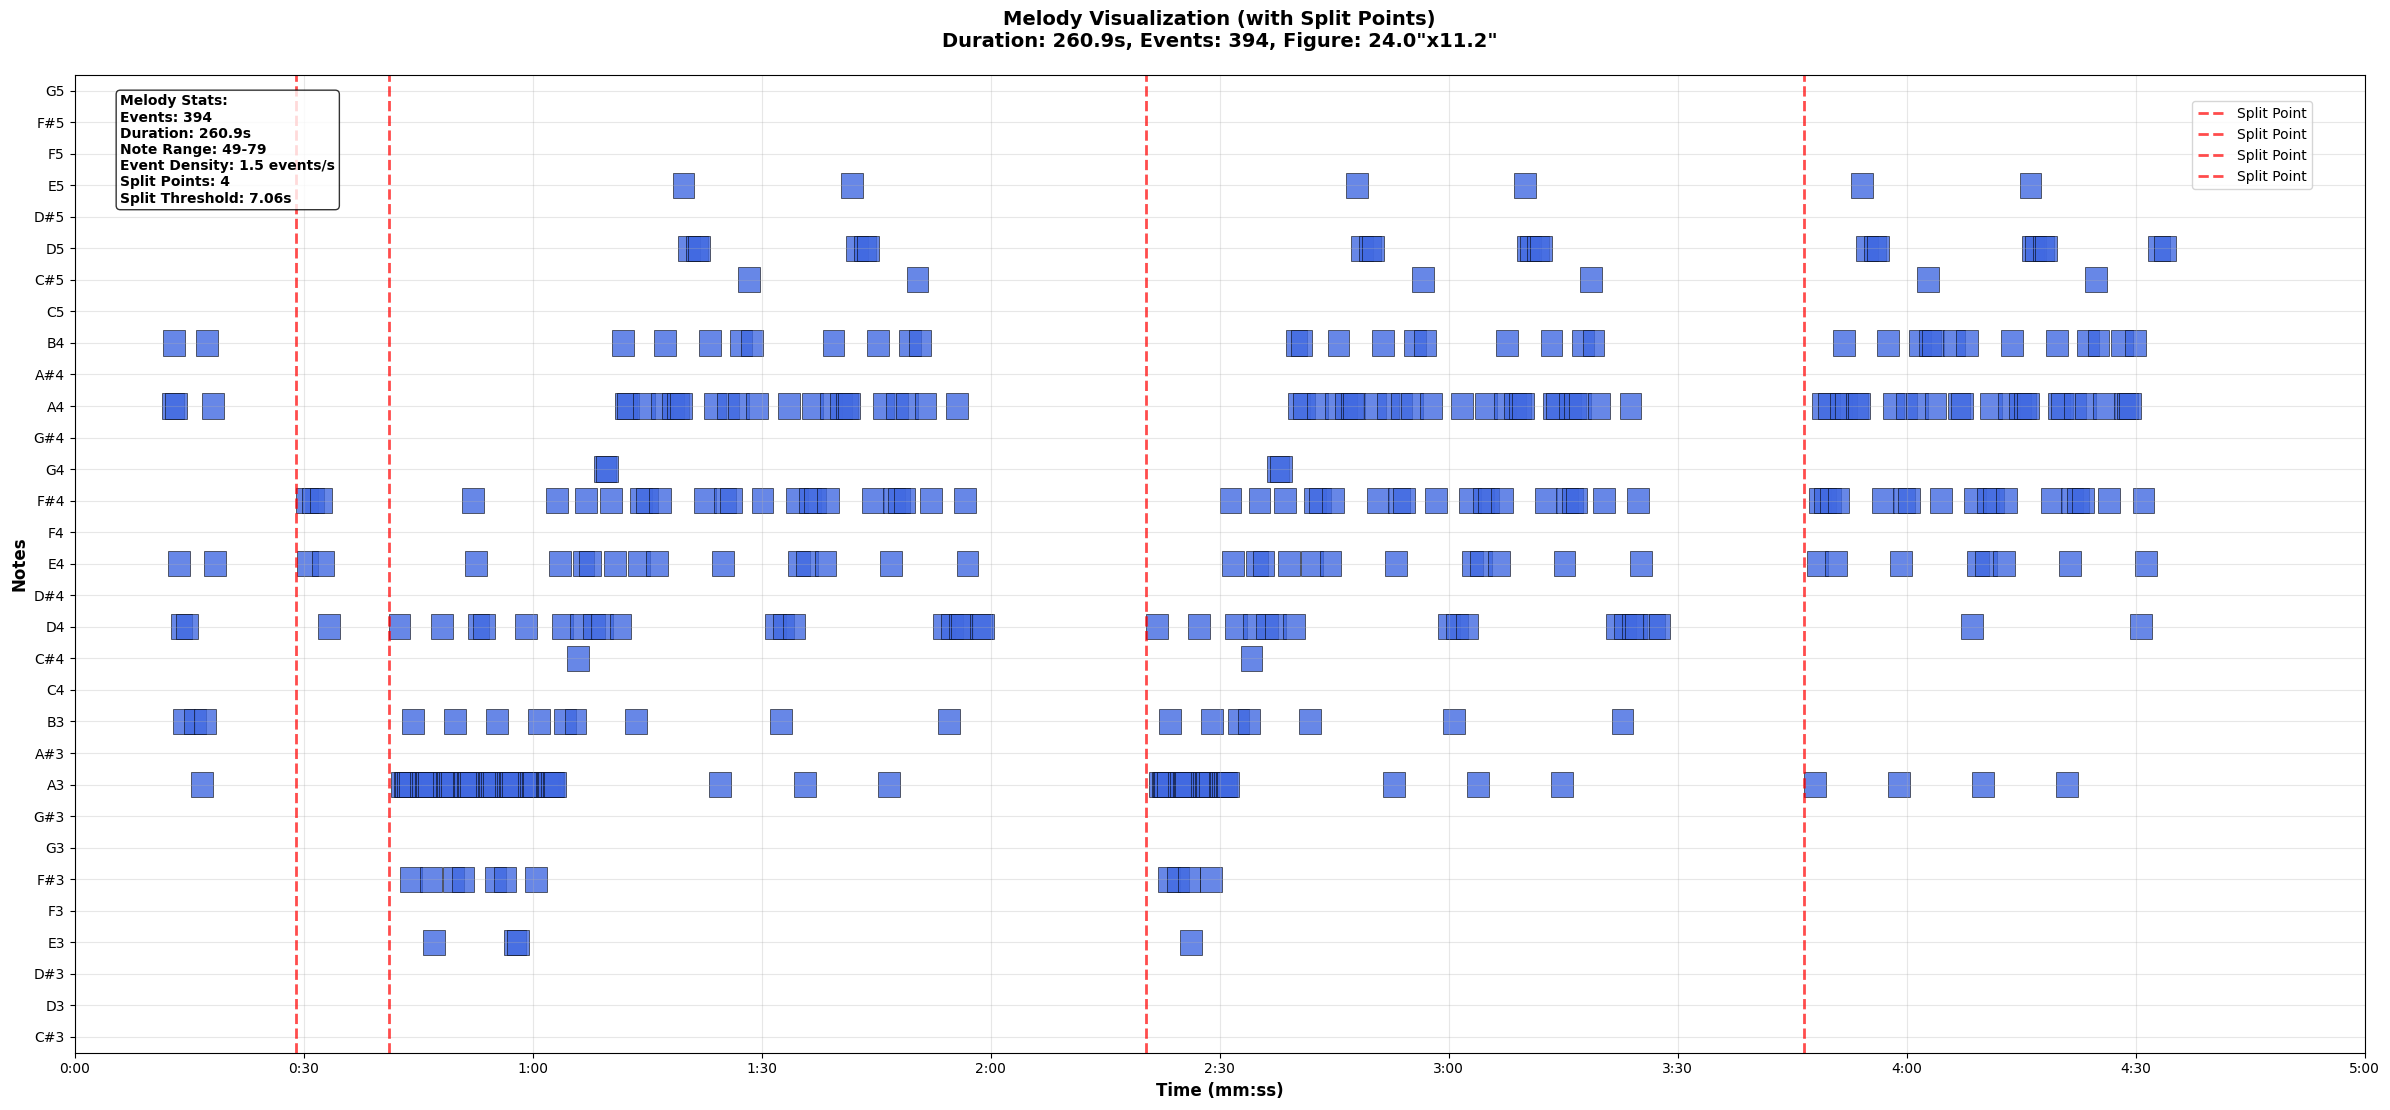

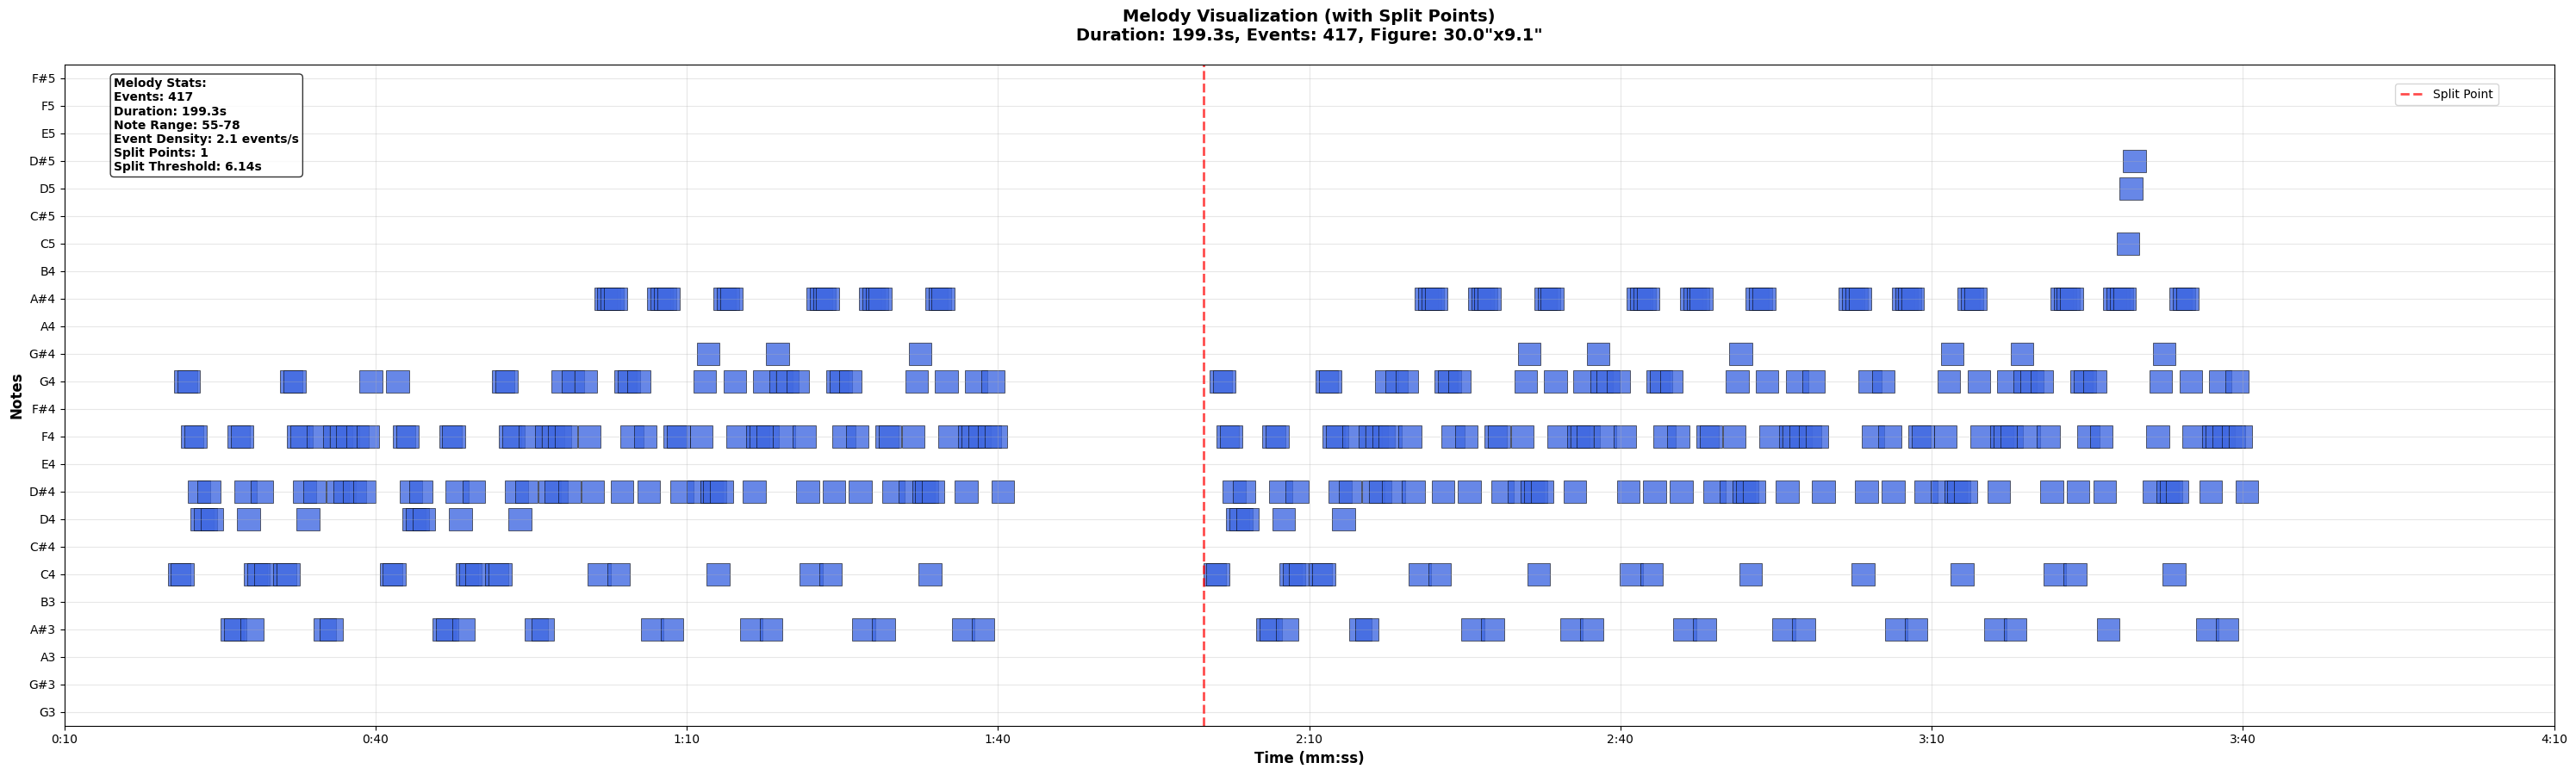

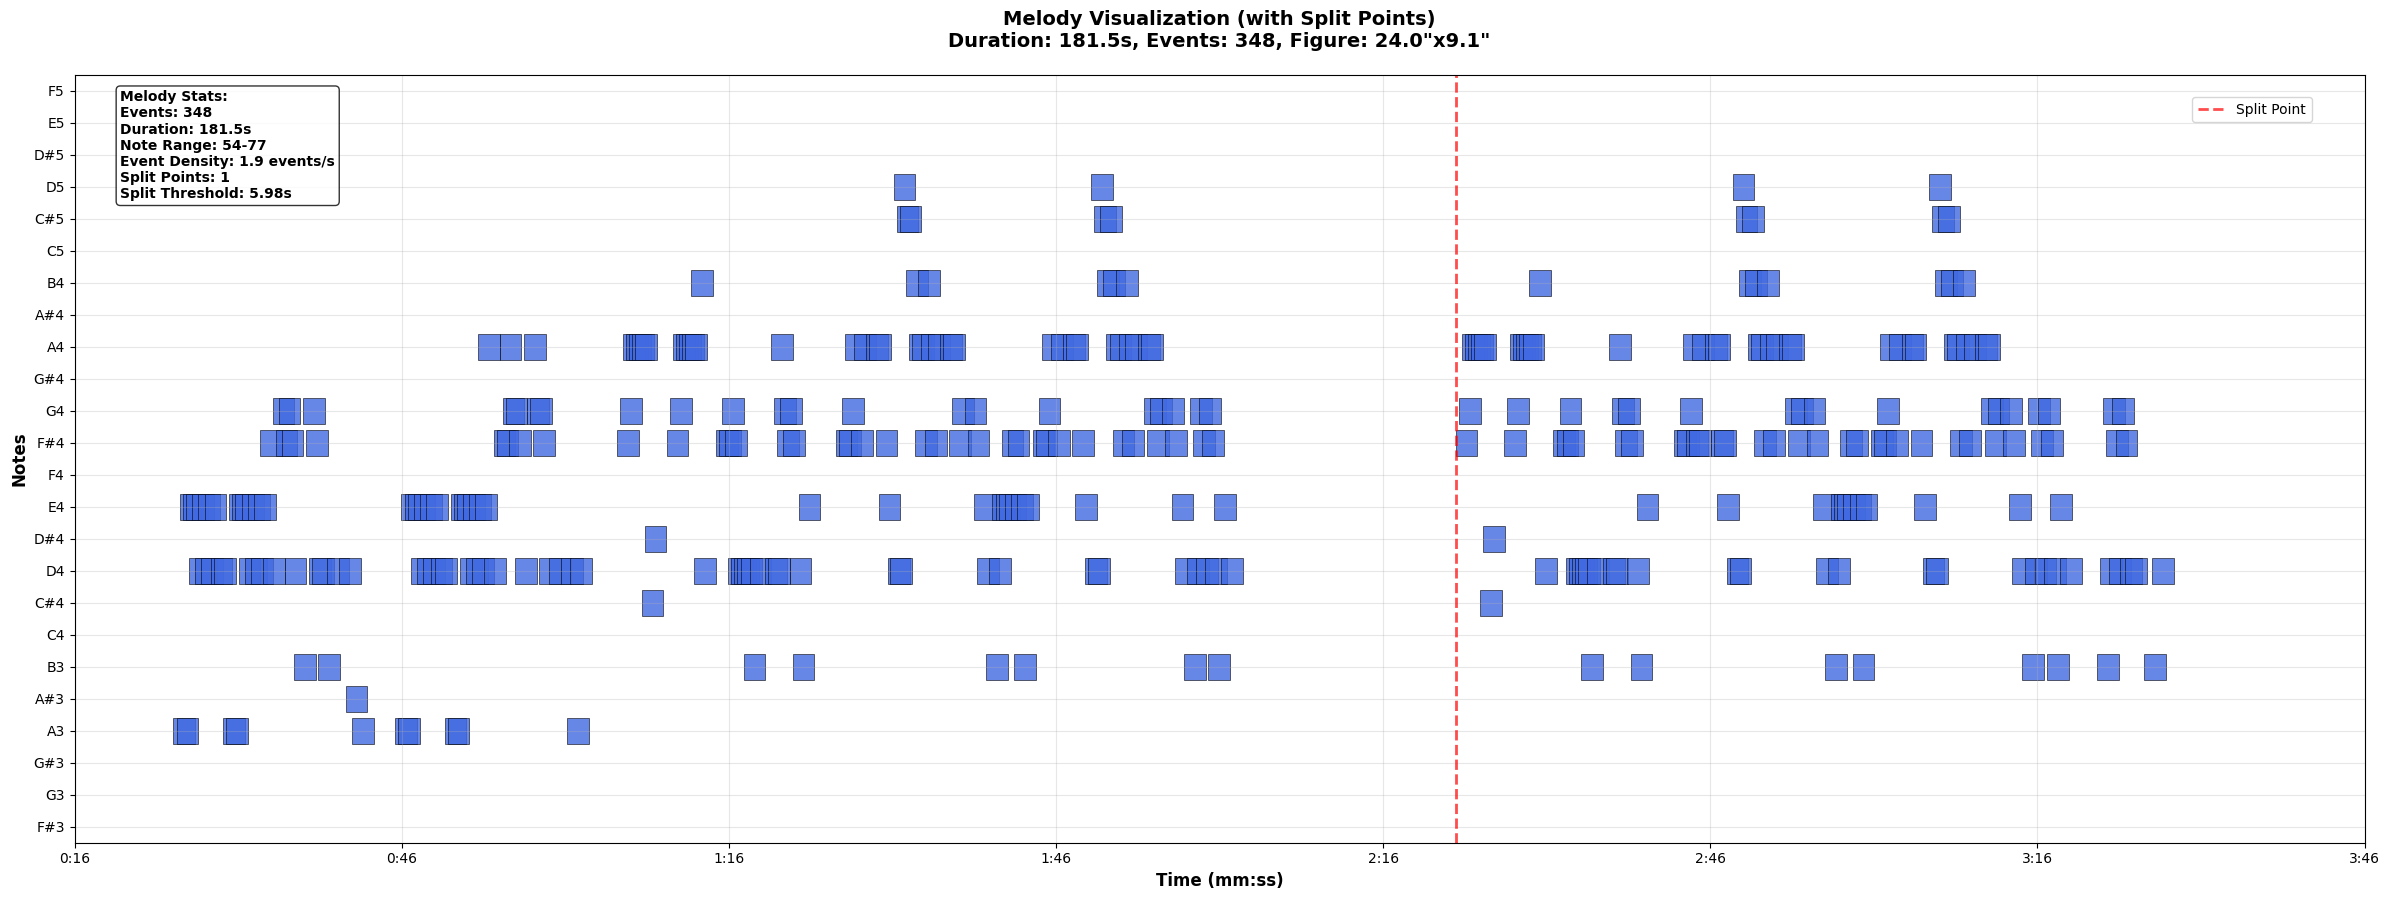

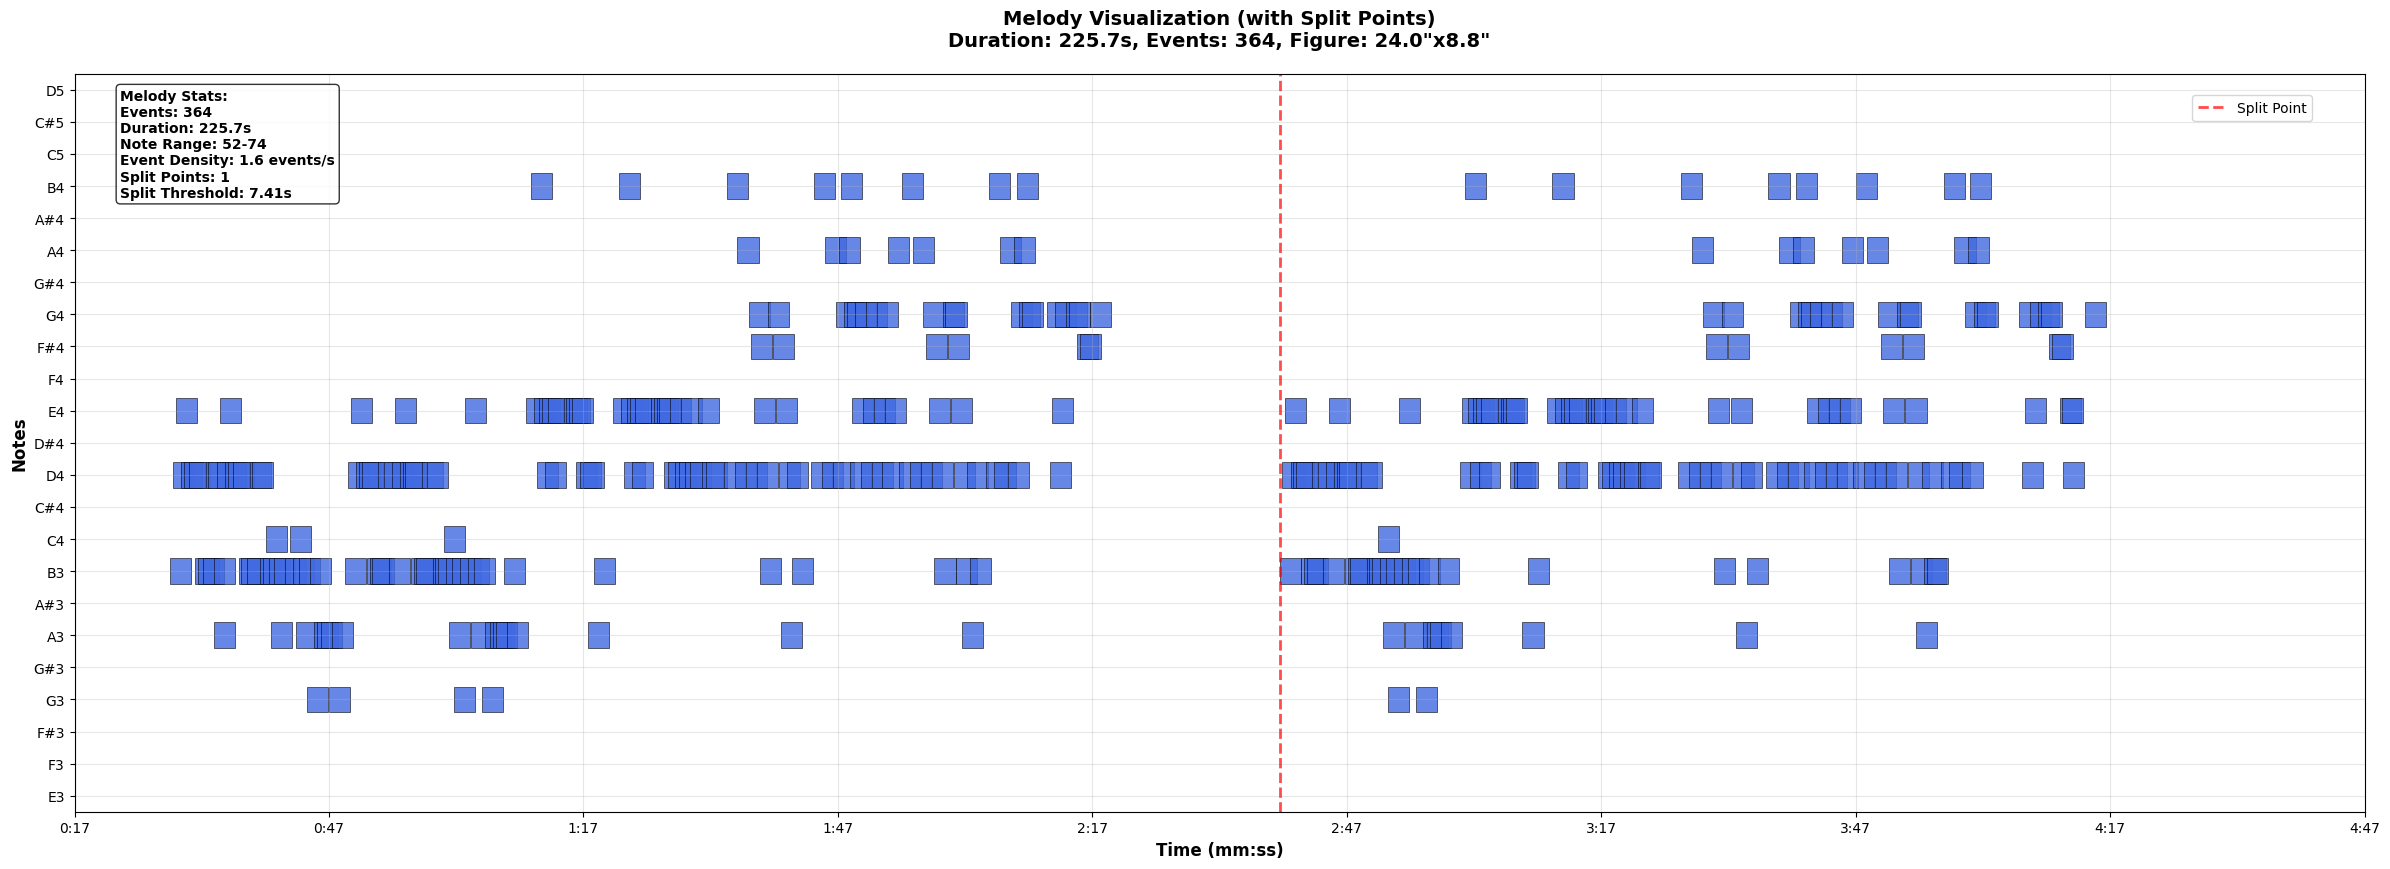

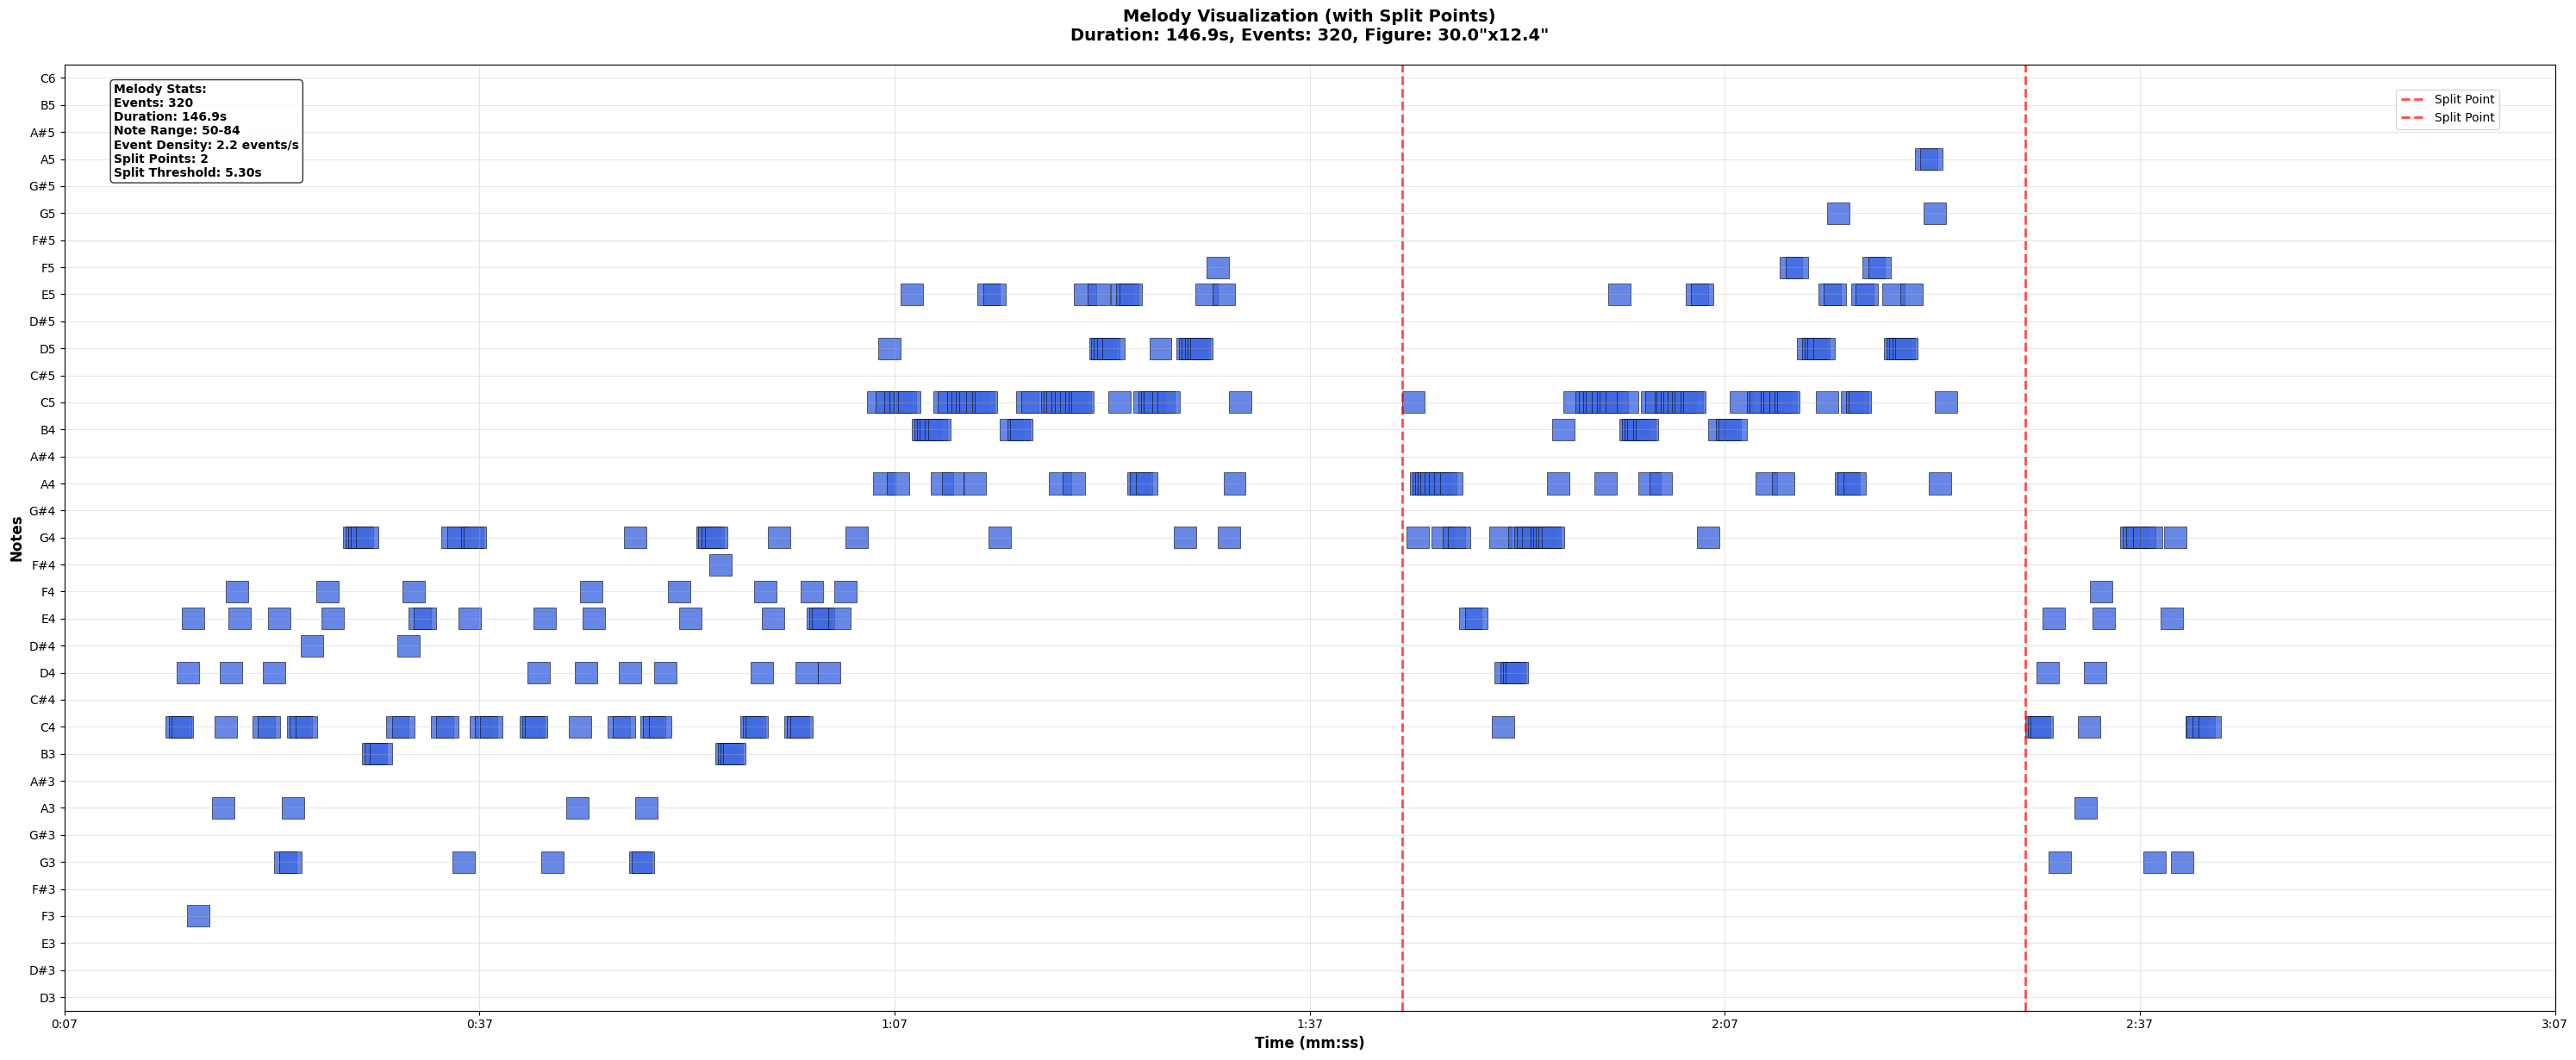

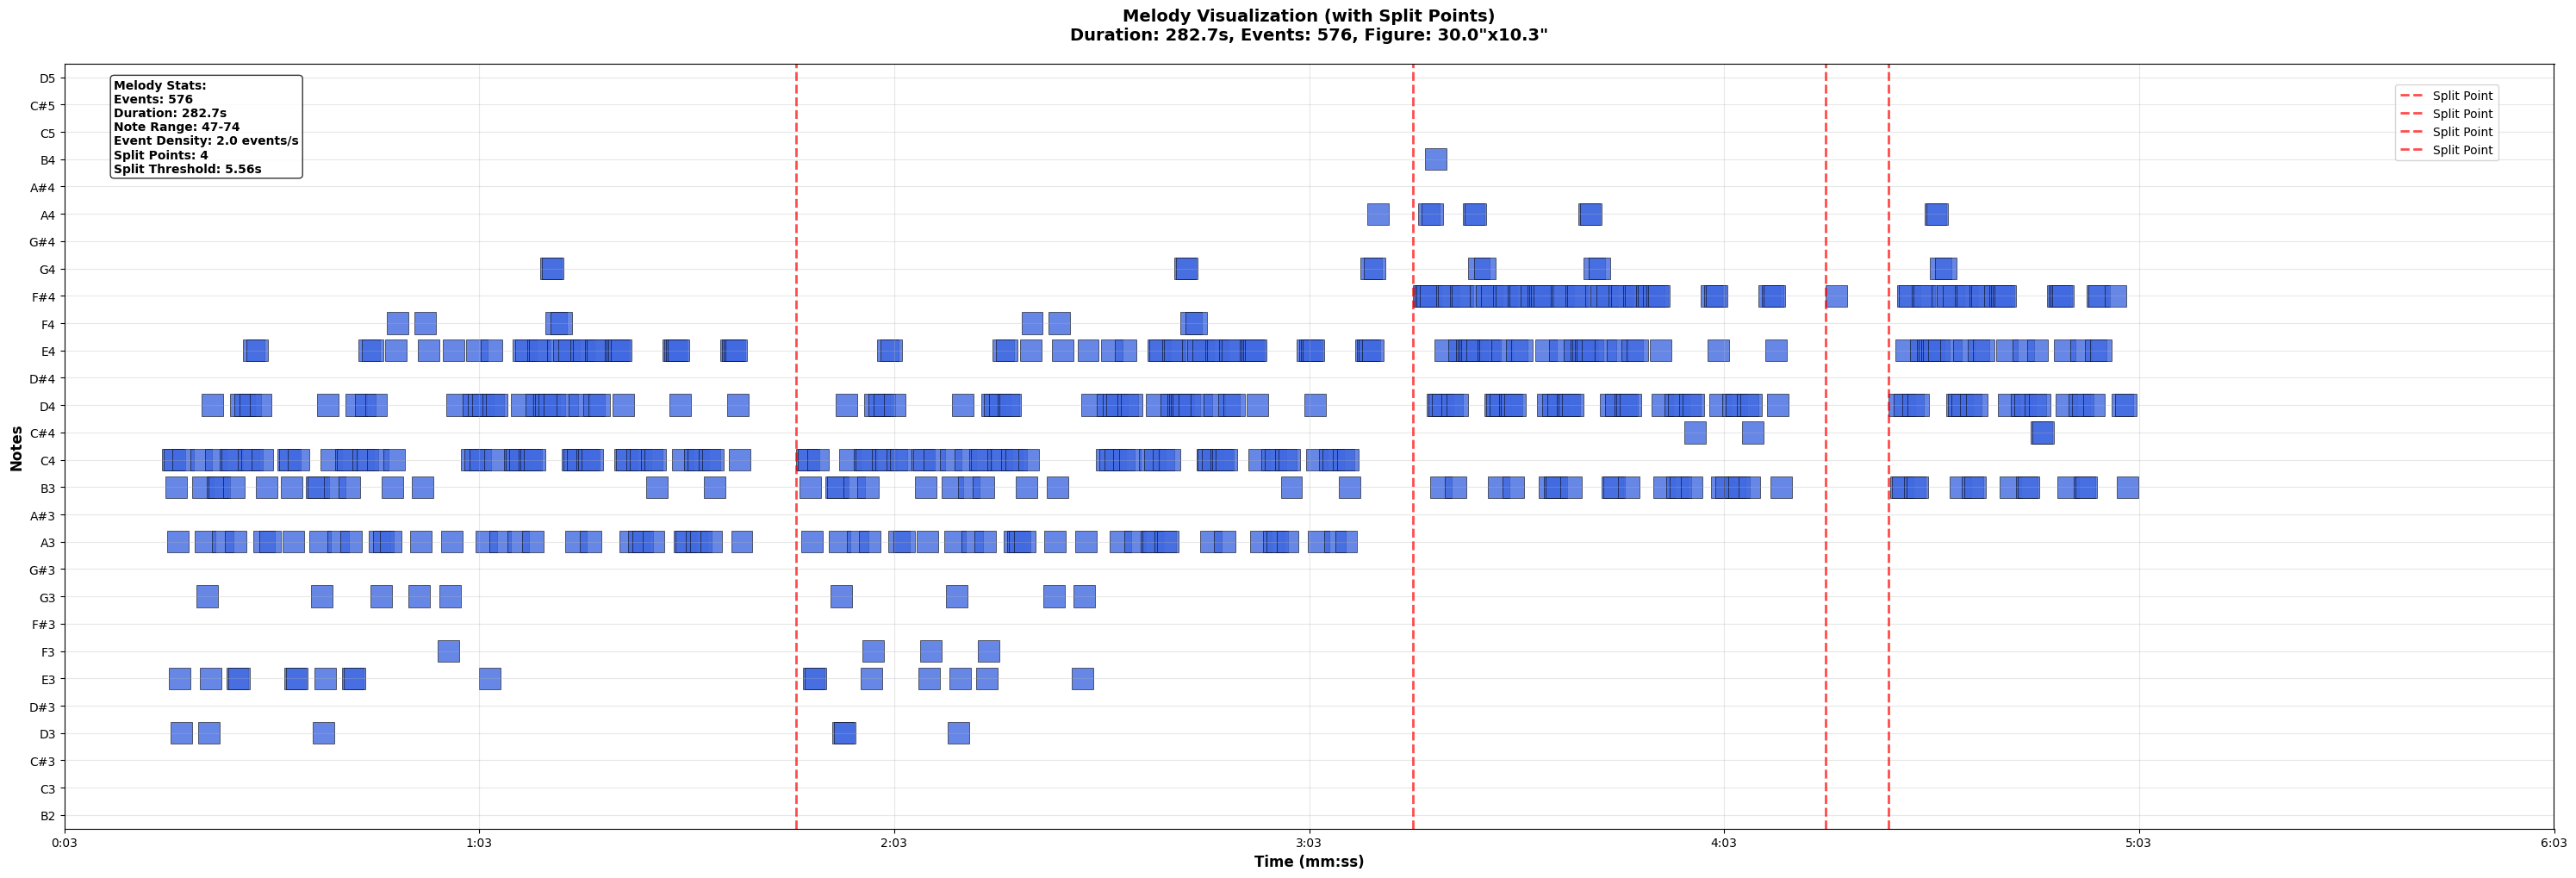

In [2]:
for song in dataset:
    song.melody.plot(
        save_path=f"results/{song.name}.png",
        show_plot=False,
        show_splits=True)

# Benchmark

In [2]:
import exmel

In [3]:
result = {}
for hop_length in [256, 128, 64, 32, 16, 8, 4, 2, 1]:
    result[hop_length] = exmel.eval_pipeline(
        exmel.AlignConfig(
            hop_length=hop_length,
            score_func=exmel.weighted_sum_velocity,
            miss_tolerance=1),
        "dataset",
        baseline=False,
        verbose=1)

Processing songs: 100%|██████████| 17/17 [05:22<00:00, 18.98s/it]


In [4]:
# miss_tolerance=1
for key, df in result.items():
    print(key, df.iloc[-1]["Alignment_F1"], df.iloc[-1]["Runtime_seconds"])

256 0.6197996057889048 0.13831340565400965
128 0.7459287684548493 0.18967596222372615
64 0.8111866484358147 0.3037620291990392
32 0.8628124533911248 0.5424133469076717
16 0.8900616044042607 1.0617415624506332
8 0.9082528775656166 2.0147251662086036
4 0.9160584596256579 4.025630656410666
2 0.9181832008750043 8.703243592206169
1 0.9204746175902949 18.890823448405545


In [9]:
# miss_tolerance=4
for key, df in result.items():
    print(key, df.iloc[-1]["Alignment_F1"], df.iloc[-1]["Runtime_seconds"])

8 0.9194101401181229 6.515273879556095
4 0.9225080478026458 13.213040365892297
2 0.9240217294308339 27.0201730447657
1 0.924595793956039 56.471663797602936


In [ ]:
# miss_tolerance=3
for key, df in result.items():
    print(key, df.iloc[-1]["Alignment_F1"], df.iloc[-1]["Runtime_seconds"])

256 0.7634355784883803 0.27773603271035585
128 0.8497955913709512 0.42850612191592946
64 0.8768626492358841 0.7046129703521729
32 0.8936165317725949 1.2633976515601664
16 0.9082263811567665 2.4860374647028305


In [8]:
result[1].to_csv("result.csv")

In [3]:
for key, df in result.items():
    print(key, df.iloc[-1]["Alignment_F1"])

8 0.9078290832665307
4 0.9124898487152128
2 0.9147433246371105
1 0.917068563758628


In [4]:
df = exmel.eval_pipeline(
        configs["best"], "dataset",
        save_plot=False,
        save_csv=False,
        save_mid=False,
        save_params=False,
        baseline=False,
        verbose=True)

Aligning <My Heart Will Go On> (1/17)...


Scanning alignments: 100%|██████████| 106/106 [00:14<00:00,  7.49it/s]


Alignment: 76.6% 71.1% 73.8%
Runtime: 14.224s
Aligning <不为谁而作的歌> (2/17)...


Scanning alignments: 100%|██████████| 182/182 [00:18<00:00,  9.70it/s]


Alignment: 90.7% 91.7% 91.2%
Runtime: 18.854s
Aligning <以父之名> (3/17)...


Scanning alignments: 100%|██████████| 396/396 [00:51<00:00,  7.63it/s]


Alignment: 95.8% 79.8% 87.1%
Runtime: 52.221s
Aligning <光年之外> (4/17)...


Scanning alignments: 100%|██████████| 223/223 [00:24<00:00,  9.20it/s]


Alignment: 99.8% 95.5% 97.6%
Runtime: 24.400s
Aligning <凉凉> (5/17)...


Scanning alignments: 100%|██████████| 170/170 [00:13<00:00, 12.93it/s]


Alignment: 85.6% 80.7% 83.1%
Runtime: 13.253s
Aligning <唯一> (6/17)...


Scanning alignments: 100%|██████████| 96/96 [00:05<00:00, 18.91it/s]


Alignment: 98.5% 84.8% 91.1%
Runtime: 5.119s
Aligning <想见你想见你想见你> (7/17)...


Scanning alignments: 100%|██████████| 254/254 [00:19<00:00, 13.30it/s]


Alignment: 95.9% 83.8% 89.5%
Runtime: 19.167s
Aligning <慢慢喜欢你> (8/17)...


Scanning alignments: 100%|██████████| 159/159 [00:07<00:00, 19.93it/s]


Alignment: 99.0% 98.3% 98.6%
Runtime: 8.066s
Aligning <明天会更好> (9/17)...


Scanning alignments: 100%|██████████| 326/326 [00:41<00:00,  7.83it/s]


Alignment: 90.5% 75.5% 82.4%
Runtime: 41.776s
Aligning <是妈妈是女儿> (10/17)...


Scanning alignments: 100%|██████████| 270/270 [00:17<00:00, 15.04it/s]


Alignment: 98.3% 93.0% 95.5%
Runtime: 18.168s
Aligning <暗号> (11/17)...


Scanning alignments: 100%|██████████| 261/261 [00:36<00:00,  7.09it/s]


Alignment: 88.7% 88.3% 88.5%
Runtime: 37.064s
Aligning <月牙湾> (12/17)...


Scanning alignments: 100%|██████████| 176/176 [00:14<00:00, 12.38it/s]


Alignment: 98.8% 92.0% 95.3%
Runtime: 14.340s
Aligning <来迟> (13/17)...


Scanning alignments: 100%|██████████| 199/199 [00:15<00:00, 13.07it/s]


Alignment: 99.8% 92.1% 95.8%
Runtime: 15.353s
Aligning <梦一场> (14/17)...


Scanning alignments: 100%|██████████| 164/164 [00:10<00:00, 15.30it/s]


Alignment: 89.3% 84.0% 86.5%
Runtime: 10.842s
Aligning <给电影人的情书> (15/17)...


Scanning alignments: 100%|██████████| 172/172 [00:07<00:00, 22.23it/s]


Alignment: 99.4% 94.6% 96.9%
Runtime: 7.806s
Aligning <野子> (16/17)...


Scanning alignments: 100%|██████████| 145/145 [00:10<00:00, 14.02it/s]


Alignment: 97.6% 70.2% 81.7%
Runtime: 10.395s
Aligning <黑暗骑士> (17/17)...


Scanning alignments: 100%|██████████| 269/269 [00:30<00:00,  8.70it/s]


Alignment: 99.4% 90.4% 94.7%
Runtime: 31.072s

EVALUATION RESULTS SUMMARY

Tested on 17 samples

ALIGNMENT RESULTS:
----------------------------------------
Precision: 0.943 ± 0.063
Recall:    0.862 ± 0.082
F1 Score:  0.900 ± 0.067
Total TP: 6654, FP: 382, FN: 1067

ALIGNMENT RUNTIME:
----------------------------------------
Average: 20.125s
Std Dev: 12.769s
Min:     5.119s
Max:     52.221s
Total:   342.121s


In [5]:
df

,Sample,Alignment_Precision,Alignment_Recall,Alignment_F1,Runtime_seconds
0,My Heart Will Go On,0.766393,0.711027,0.737673,14.224402
1,不为谁而作的歌,0.907104,0.917127,0.912088,18.854409
2,以父之名,0.958462,0.797695,0.870720,52.221369
3,光年之外,0.997763,0.955032,0.975930,24.399752
4,凉凉,0.855524,0.807487,0.830812,13.252935
5,唯一,0.984848,0.847826,0.911215,5.119492
6,想见你想见你想见你,0.958599,0.838440,0.894502,19.166857
7,慢慢喜欢你,0.990025,0.982673,0.986335,8.065947
8,明天会更好,0.905380,0.755418,0.823629,41.776017
9,是妈妈是女儿,0.982669,0.929508,0.955350,18.167926
